In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F



writer = SummaryWriter('runs/Bhahdanau_attention_experiment_1')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: cuda
Device name: NVIDIA GeForce GTX 1650


In [147]:
data = pd.read_csv("data/Dataset_English_Hindi.csv")
data.sample(5)

,English,Hindi
127262,"because he was, in fact, dyslexic.","क्योंकि असल में, वो डिस्लेक्सिक थे।"
22160,"Moulik , Sishir Kumar Ghose , Nirapado Roy are...","अभियुक्तों परेश चौधरी मलिक , शिशिर कुमार घोष ,..."
104635,They are wanderers and like living in tents or...,ये लोग चलते फिरते डेरा में रहते है.खुले आकश के...
88814,Nobody could work for the unity of India in su...,ऐसे वातावरण में कोई भारत की एकता के लिए पहल नह...
30628,This is what you see.,आपको यहाँ येही दिखाई देगा


In [148]:
mask = data['English'].apply(lambda x: isinstance(x, str)) & data['Hindi'].apply(lambda x: isinstance(x, str))
data = data.loc[mask].copy()
data['English'] = data['English'].str.lower()
data['Hindi'] = data['Hindi'].str.lower()

In [149]:
MAX_SENT_LEN = 15
data = data[data['English'].str.split().apply(len) < MAX_SENT_LEN].copy()
data.reset_index(drop=True, inplace=True)
print(f"Rows after filtering: {len(data)}")

Rows after filtering: 77743


<Axes: title={'center': 'Distribution of English Sentence Lengths'}, ylabel='Frequency'>

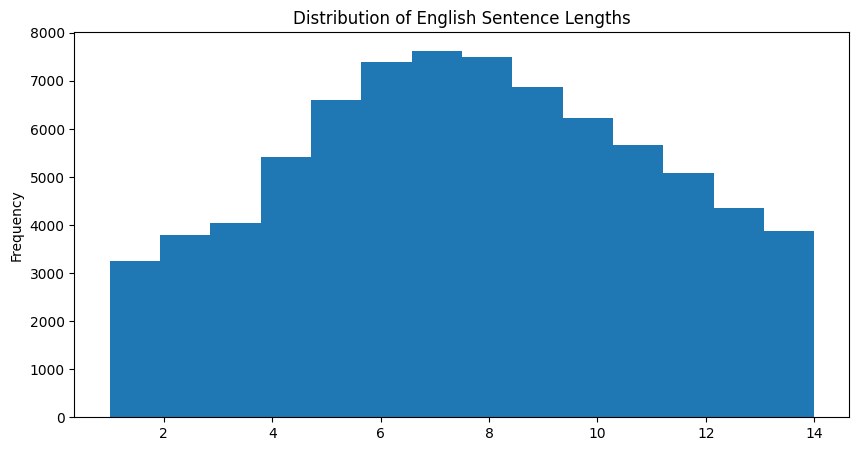

In [150]:
data['English'].str.split().apply(len).plot(kind='hist', bins=14, title='Distribution of English Sentence Lengths', figsize=(10, 5))

In [151]:
class Tokenizer:
    def __init__(self, texts):
        self.oov_token = "<|unknown|>"
        self.start_token = "<|startoftext|>"
        self.end_token = "<|endoftext|>"
        self.padding_token = "<|pad|>"
        self.word_index = {self.oov_token: 0, self.start_token: 1, self.end_token: 2, self.padding_token: 3}
    
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')

            text = text.split()
            for word in text:
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index) + 1
        self.index_word = {idx : word for word, idx in self.word_index.items()}

        self.vocab_size = len(self.word_index)
    def encode(self, texts):
        tokenized_texts = []
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')
            tokenized_text = []
            text = text.split()
            for word in text:
                tokenized_text.append(self.word_index.get(word, self.word_index[self.oov_token]))
            tokenized_texts.append(tokenized_text)
        return tokenized_texts
    def decode(self, sequences):
        decoded_texts = []
        for sequence in sequences:
            decoded_text = []
            for index in sequence:
                decoded_text.append(self.index_word.get(index, self.oov_token))
            decoded_texts.append(' '.join(decoded_text))
        return decoded_texts

In [152]:
eng_tokenizer = Tokenizer(data['English'])
hin_tokenizer = Tokenizer(data['Hindi'])
print(f"English Vocabulary Size: {eng_tokenizer.vocab_size}")# 80223
print(f"Hindi Vocabulary Size: {hin_tokenizer.vocab_size}")# 85059

English Vocabulary Size: 43114
Hindi Vocabulary Size: 43014


In [153]:
tokenized_text = eng_tokenizer.encode(["hello how are you raj neelam gaurav convolution", "this is a test", "what is your name"])
print(tokenized_text)
print(eng_tokenizer.decode(tokenized_text))
print()
tokenized_text = hin_tokenizer.encode(["नमस्ते आप कैसे हैं राज नीलम गौरव कन्वोल्यूशन", "यह एक परीक्षण है", "तुम्हारा नाम क्या है"])
print(tokenized_text)
print(hin_tokenizer.decode(tokenized_text))

[[7, 82, 83, 62, 8266, 26951, 0, 0], [94, 104, 110, 2144], [123, 104, 183, 306]]
['hello how are you raj neelam <|unknown|> <|unknown|>', 'this is a test', 'what is your name']

[[27205, 122, 123, 124, 3305, 28591, 5206, 0], [143, 111, 14354, 80], [404, 433, 114, 80]]
['नमस्ते आप कैसे हैं राज नीलम गौरव <|unknown|>', 'यह एक परीक्षण है', 'तुम्हारा नाम क्या है']


In [154]:
EMBED_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 128

START_LR = 0.005
END_LR = 0.000001
TOTAL_EPOCHS = 30

In [155]:
data, test_data = train_test_split(data, test_size=0.1)
len(data), len(test_data)

(69968, 7775)

In [156]:
# shuffle data
print(data.head())
data = data.sample(frac=1).reset_index(drop=True)
print(data.head())

                                      English  \
50590  or if they get an extra ration of food   
77309   or con thing, but now it is in thing.   
73400    this wars main anchors were also 18|   
1531          both he and his wife have cars.   
58136                because of online crime.   

                                            Hindi  
50590                अगर हफ्ते के आखिर में उन्हें  
77309         कुछ बुरी चीज़, लेकिन अब वापस आ गया।  
73400   इस युद्ध के प्रमुख सूत्रधार भी अठारह हैं।  
1531   वह और उसकी पत्नी दोनो के पास गाड़ियाँ हैं।  
58136                    ऑनलाइन अपराध की वजह से .  
                                             English  \
0                    about the middle east conflict.   
1                           this lady, she developed   
2  the internal room of tajmahal is very differen...   
3  i feel angry when i see cruelty to human being...   
4                     that sort of phallic bit there   

                                               Hindi  
0

In [157]:
class MyDataset(Dataset):
    def __init__(self, data, eng_tokenizer, hin_tokenizer):
        self.data = data
        self.eng_tokenizer = eng_tokenizer
        self.hin_tokenizer = hin_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng_text = self.data.iloc[idx]['English']
        hin_text = self.data.iloc[idx]['Hindi']

        eng_tokenized = self.eng_tokenizer.encode([eng_text])[0]
        if len(eng_tokenized) > MAX_SENT_LEN:
            eng_tokenized = eng_tokenized[:MAX_SENT_LEN]

        eng_padded = [self.eng_tokenizer.word_index[self.eng_tokenizer.padding_token]] * (MAX_SENT_LEN - len(eng_tokenized)) + eng_tokenized

        hin_tokenized = self.hin_tokenizer.encode([hin_text])[0]

        if len(hin_tokenized) > MAX_SENT_LEN - 2:
            hin_tokenized = hin_tokenized[:MAX_SENT_LEN - 2]
        hin_padded = [self.hin_tokenizer.word_index[self.hin_tokenizer.start_token]] + hin_tokenized + [self.hin_tokenizer.word_index[self.hin_tokenizer.end_token]] + [self.hin_tokenizer.word_index[self.hin_tokenizer.padding_token]] * (MAX_SENT_LEN - len(hin_tokenized) - 2)

        return {
            'eng_input': torch.tensor(eng_padded),
            'hin_target': torch.tensor(hin_padded)
        }

dataset = DataLoader(MyDataset(data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)
test_dataset = DataLoader(MyDataset(test_data, eng_tokenizer, hin_tokenizer), batch_size=BATCH_SIZE, shuffle=True)

In [158]:
class Encoder(nn.Module):
    def __init__(self, input_dim, num_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, EMBED_DIM)
        self.rnn = nn.GRU(EMBED_DIM, HIDDEN_DIM, num_layers, batch_first=True)

    def forward(self, src):
        """
        src: (batch_size, src_len)
        """
        embedded = self.embedding(src)               # (B, T, E)
        outputs, hidden = self.rnn(embedded)         # outputs: all h_t, hidden: last h_T
        return outputs, hidden                       # hidden = context vector

In [159]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim) # For encoder outputs
        self.W2 = nn.Linear(hidden_dim, hidden_dim) # For decoder hidden state
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (num_layers, B, H) -> we take the top layer
        # encoder_outputs: (B, T, H)
        
        # We use the last layer of the decoder hidden state
        last_hidden = decoder_hidden[-1].unsqueeze(1) # (B, 1, H)
        
        # Calculate scores: V * tanh(W1(enc) + W2(dec))
        # (B, T, H) + (B, 1, H) -> (B, T, H) via broadcasting
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(last_hidden)))
        
        # score: (B, T, 1) -> weights: (B, 1, T)
        attention_weights = F.softmax(score, dim=1).transpose(1, 2)
        
        # context_vector: (B, 1, T) @ (B, T, H) -> (B, 1, H)
        context_vector = torch.bmm(attention_weights, encoder_outputs)
        
        return context_vector, attention_weights

In [160]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers=3):
        super().__init__()
        self.attention = BahdanauAttention(hidden_dim)
        self.embedding = nn.Embedding(output_dim, embed_dim)
        
        # GRU input: embedding + context vector
        self.rnn = nn.GRU(embed_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim + hidden_dim + embed_dim, output_dim)

    def forward(self, input_token, hidden, encoder_outputs):
        # input_token: (B)
        input_token = input_token.unsqueeze(1) # (B, 1)
        embedded = self.embedding(input_token) # (B, 1, E)

        # 1. Get attention context
        context, weights = self.attention(hidden, encoder_outputs)

        # 2. Concatenate embedding and context
        rnn_input = torch.cat((embedded, context), dim=2) # (B, 1, E + H)

        # 3. Feed to RNN
        output, hidden = self.rnn(rnn_input, hidden)

        # 4. Predict (Final FC can use context, rnn_output, and embedding)
        prediction = self.fc(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim=1))

        return prediction, hidden, weights

In [161]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        
        # Get all encoder hidden states
        encoder_outputs, hidden = self.encoder(src)

        input_token = trg[:, 0] # <start> token

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            outputs[:, t] = output
            
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs

In [162]:
encoder = Encoder(input_dim=eng_tokenizer.vocab_size+1)
decoder = Decoder(output_dim=hin_tokenizer.vocab_size+1, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM)

model = Seq2Seq(encoder, decoder, device).to(device)


In [97]:
data_iter = iter(dataset)
sample_batch = next(data_iter)
X_sample = sample_batch['eng_input'].to(device)
y_sample = sample_batch['hin_target'].to(device)
writer.add_graph(model, [X_sample, y_sample])

C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:24: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  teacher_force = torch.rand(1).item() < teacher_forcing_ratio
c:\Python310\lib\site-packages\torch\jit\_trace.py:1209: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 71557553 / 82588800 (86.6%)
Greatest absolute difference: 2.0307735204696655 at index (19, 5, 7991) (up to 1e-05 allowed)
Greatest relative difference: 44533239.85714286 at index (3, 3, 15525) (up to 1e-05 allowed)
  _check_trace(


TracingCheckError: Tracing failed sanity checks!
ERROR: Graphs differed across invocations!
	Graph diff:
		  graph(%self.1 : __torch__.Seq2Seq,
		        %src : Tensor,
		        %trg : Tensor):
		    %decoder : __torch__.Decoder = prim::GetAttr[name="decoder"](%self.1)
		    %encoder : __torch__.Encoder = prim::GetAttr[name="encoder"](%self.1)
		    %5 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:9:0
		    %6 : int = aten::size(%src, %5) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:9:0
		    %batch_size : Tensor = prim::NumToTensor(%6)
		    %8 : int = aten::Int(%batch_size)
		    %9 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:10:0
		    %10 : int = aten::size(%trg, %9) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:10:0
		    %trg_len : Tensor = prim::NumToTensor(%10)
		    %12 : int = aten::Int(%trg_len)
		    %13 : int = prim::Constant[value=43015]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %14 : int[] = prim::ListConstruct(%8, %12, %13)
		    %15 : NoneType = prim::Constant()
		    %16 : NoneType = prim::Constant()
		    %17 : Device = prim::Constant[value="cpu"]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %18 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %19 : Tensor = aten::zeros(%14, %15, %16, %17, %18) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %20 : int = prim::Constant[value=6]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %21 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %22 : Device = prim::Constant[value="cuda"]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %23 : NoneType = prim::Constant()
		    %24 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %25 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		    %26 : NoneType = prim::Constant()
		    %outputs : Tensor = aten::to(%19, %20, %21, %22, %23, %24, %25, %26) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:13:0
		-   %293 : int = prim::Constant[value=0](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1375:0
		?    --
		+   %303 : int = prim::Constant[value=0](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1375:0
		?     ++
		-   %294 : int = prim::Constant[value=3](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?    ^^
		+   %304 : int = prim::Constant[value=3](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?    ^^
		-   %295 : int = prim::Constant[value=256](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?    ^^
		+   %305 : int = prim::Constant[value=256](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?    ^^
		-   %296 : int = prim::Constant[value=6](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?    ^^
		+   %306 : int = prim::Constant[value=6](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?    ^^
		-   %297 : NoneType = prim::Constant(), scope: __module.encoder/__module.encoder.rnn
		?    ^^
		+   %307 : NoneType = prim::Constant(), scope: __module.encoder/__module.encoder.rnn
		?    ^^
		-   %298 : Device = prim::Constant[value="cuda:0"](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?    ^^
		+   %308 : Device = prim::Constant[value="cuda:0"](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?    ^^
		-   %299 : bool = prim::Constant[value=1](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?    ^ -
		+   %309 : bool = prim::Constant[value=1](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?    ^^
		-   %300 : float = prim::Constant[value=0.](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      -
		+   %310 : float = prim::Constant[value=0.](), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     +
		-   %301 : int = prim::Constant[value=-1](), scope: __module.encoder/__module.encoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     -
		+   %311 : int = prim::Constant[value=-1](), scope: __module.encoder/__module.encoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      +
		-   %302 : bool = prim::Constant[value=0](), scope: __module.encoder/__module.encoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %312 : bool = prim::Constant[value=0](), scope: __module.encoder/__module.encoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		    %rnn.1 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%encoder)
		    %embedding.1 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%encoder)
		    %weight.5 : Tensor = prim::GetAttr[name="weight"](%embedding.1)
		-   %input.1 : Tensor = aten::embedding(%weight.5, %src, %301, %302, %302), scope: __module.encoder/__module.encoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                          ^     ^     ^
		+   %input.1 : Tensor = aten::embedding(%weight.5, %src, %311, %312, %312), scope: __module.encoder/__module.encoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                          ^     ^     ^
		    %bias_hh_l2.1 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.1)
		    %bias_ih_l2.1 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.1)
		    %weight_hh_l2.1 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.1)
		    %weight_ih_l2.1 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.1)
		    %bias_hh_l1.1 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.1)
		    %bias_ih_l1.1 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.1)
		    %weight_hh_l1.1 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.1)
		    %weight_ih_l1.1 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.1)
		    %bias_hh_l0.1 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.1)
		    %bias_ih_l0.1 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.1)
		    %weight_hh_l0.1 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.1)
		    %weight_ih_l0.1 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.1)
		-   %319 : int = aten::size(%input.1, %293), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1375:0
		?     ^                                ^^
		+   %329 : int = aten::size(%input.1, %303), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1375:0
		?     ^                                ^^
		-   %320 : int[] = prim::ListConstruct(%294, %319, %295), scope: __module.encoder/__module.encoder.rnn
		?     ^                                   -    ^^^^^^^
		+   %330 : int[] = prim::ListConstruct(%304, %329, %305), scope: __module.encoder/__module.encoder.rnn
		?     ^                                 +++++++      ^
		-   %hx : Tensor = aten::zeros(%320, %296, %297, %298, %302), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?                                ^  ------------------
		+   %hx : Tensor = aten::zeros(%330, %306, %307, %308, %312), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1380:0
		?                                ^      ++++++++++++++++++
		-   %322 : Tensor[] = prim::ListConstruct(%weight_ih_l0.1, %weight_hh_l0.1, %bias_ih_l0.1, %bias_hh_l0.1, %weight_ih_l1.1, %weight_hh_l1.1, %bias_ih_l1.1, %bias_hh_l1.1, %weight_ih_l2.1, %weight_hh_l2.1, %bias_ih_l2.1, %bias_hh_l2.1), scope: __module.encoder/__module.encoder.rnn
		?     ^^^^
		+   %332 : Tensor[] = prim::ListConstruct(%weight_ih_l0.1, %weight_hh_l0.1, %bias_ih_l0.1, %bias_hh_l0.1, %weight_ih_l1.1, %weight_hh_l1.1, %bias_ih_l1.1, %bias_hh_l1.1, %weight_ih_l2.1, %weight_hh_l2.1, %bias_ih_l2.1, %bias_hh_l2.1), scope: __module.encoder/__module.encoder.rnn
		?     ^^^^
		-   %input.5 : Tensor, %decoder_hidden.1 : Tensor = aten::gru(%input.1, %hx, %322, %299, %294, %300, %302, %302, %299), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
		+   %input.5 : Tensor, %decoder_hidden.1 : Tensor = aten::gru(%input.1, %hx, %332, %309, %304, %310, %312, %312, %309), scope: __module.encoder/__module.encoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                             +  +++++++++++++++++++++++    ++ ^^^^^
		-   %325 : (Tensor, Tensor) = prim::TupleConstruct(%decoder_hidden.1, %input.5)
		?     ^
		+   %335 : (Tensor, Tensor) = prim::TupleConstruct(%decoder_hidden.1, %input.5)
		?     ^
		-   %326 : Tensor, %327 : Tensor = prim::TupleUnpack(%325)
		?     ^              ^                                 ^
		+   %336 : Tensor, %337 : Tensor = prim::TupleUnpack(%335)
		?     ^              ^                                 ^
		-   %328 : (Tensor, Tensor) = prim::TupleConstruct(%326, %327)
		?     ^                                              ^     ^
		+   %338 : (Tensor, Tensor) = prim::TupleConstruct(%336, %337)
		?     ^                                              ^     ^
		-   %29 : Tensor, %30 : Tensor = prim::TupleUnpack(%328)
		?                                                    ^
		+   %29 : Tensor, %30 : Tensor = prim::TupleUnpack(%338)
		?                                                    ^
		    %31 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:18:0
		    %32 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:18:0
		    %33 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:18:0
		    %34 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:18:0
		    %35 : Tensor = aten::slice(%trg, %31, %32, %33, %34) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:18:0
		    %36 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:18:0
		    %37 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:18:0
		    %input_token.1 : Tensor = aten::select(%35, %36, %37) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:18:0
		-   %329 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %339 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %330 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %340 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %331 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %341 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %332 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		+   %342 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		-   %333 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?      -
		+   %343 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     +
		-   %334 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     -
		+   %344 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?      +
		-   %335 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %345 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %336 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %346 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %337 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		+   %347 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		    %fc.1 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.3 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.1 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.3 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.3 : Tensor = aten::unsqueeze(%input_token.1, %337), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                         ^
		+   %input.3 : Tensor = aten::unsqueeze(%input_token.1, %347), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                         ^
		    %weight.7 : Tensor = prim::GetAttr[name="weight"](%embedding.3)
		-   %embedded.1 : Tensor = aten::embedding(%weight.7, %input.3, %335, %336, %336), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                 ^     ^     ^
		+   %embedded.1 : Tensor = aten::embedding(%weight.7, %input.3, %345, %346, %346), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                 ^     ^     ^
		    %V.1 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.1)
		    %W2.1 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.1)
		    %W1.1 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.1)
		-   %348 : Tensor = aten::select(%29, %332, %335), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                                 ^     ^
		+   %358 : Tensor = aten::select(%29, %342, %345), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                                 ^     ^
		-   %input.7 : Tensor = aten::unsqueeze(%348, %337), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                         ^     ^
		+   %input.7 : Tensor = aten::unsqueeze(%358, %347), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                         ^     ^
		    %bias.1 : Tensor = prim::GetAttr[name="bias"](%W1.1)
		    %weight.9 : Tensor = prim::GetAttr[name="weight"](%W1.1)
		-   %352 : Tensor = aten::linear(%30, %weight.9, %bias.1), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %362 : Tensor = aten::linear(%30, %weight.9, %bias.1), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		    %bias.3 : Tensor = prim::GetAttr[name="bias"](%W2.1)
		    %weight.11 : Tensor = prim::GetAttr[name="weight"](%W2.1)
		-   %355 : Tensor = aten::linear(%input.7, %weight.11, %bias.3), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^^^
		+   %365 : Tensor = aten::linear(%input.7, %weight.11, %bias.3), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     + ^^
		-   %356 : Tensor = aten::add(%352, %355, %337), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     -                         ^     ^     ^
		+   %366 : Tensor = aten::add(%362, %365, %347), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?      +                        ^     ^     ^
		-   %input.9 : Tensor = aten::tanh(%356), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                    ^
		+   %input.9 : Tensor = aten::tanh(%366), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                    ^
		    %bias.5 : Tensor = prim::GetAttr[name="bias"](%V.1)
		    %weight.13 : Tensor = prim::GetAttr[name="weight"](%V.1)
		    %input.11 : Tensor = aten::linear(%input.9, %weight.13, %bias.5), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %361 : Tensor = aten::softmax(%input.11, %337, %333), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                        ^     ^
		+   %371 : Tensor = aten::softmax(%input.11, %347, %343), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                        ^     ^
		-   %attention_weights.1 : Tensor = aten::transpose(%361, %337, %334), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     ^     ^     ^
		+   %attention_weights.1 : Tensor = aten::transpose(%371, %347, %344), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     ^     ^     ^
		    %context.1 : Tensor = aten::bmm(%attention_weights.1, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %364 : Tensor[] = prim::ListConstruct(%embedded.1, %context.1), scope: __module.decoder
		?     ^
		+   %374 : Tensor[] = prim::ListConstruct(%embedded.1, %context.1), scope: __module.decoder
		?     ^
		-   %input.13 : Tensor = aten::cat(%364, %334), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		+   %input.13 : Tensor = aten::cat(%374, %344), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		    %bias_hh_l2.3 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.3)
		    %bias_ih_l2.3 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.3)
		    %weight_hh_l2.3 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.3)
		    %weight_ih_l2.3 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.3)
		    %bias_hh_l1.3 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.3)
		    %bias_ih_l1.3 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.3)
		    %weight_hh_l1.3 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.3)
		    %weight_ih_l1.3 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.3)
		    %bias_hh_l0.3 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.3)
		    %bias_ih_l0.3 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.3)
		    %weight_hh_l0.3 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.3)
		    %weight_ih_l0.3 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.3)
		-   %378 : Tensor[] = prim::ListConstruct(%weight_ih_l0.3, %weight_hh_l0.3, %bias_ih_l0.3, %bias_hh_l0.3, %weight_ih_l1.3, %weight_hh_l1.3, %bias_ih_l1.3, %bias_hh_l1.3, %weight_ih_l2.3, %weight_hh_l2.3, %bias_ih_l2.3, %bias_hh_l2.3), scope: __module.decoder/__module.decoder.rnn
		?     - ^^
		+   %388 : Tensor[] = prim::ListConstruct(%weight_ih_l0.3, %weight_hh_l0.3, %bias_ih_l0.3, %bias_hh_l0.3, %weight_ih_l1.3, %weight_hh_l1.3, %bias_ih_l1.3, %bias_hh_l1.3, %weight_ih_l2.3, %weight_hh_l2.3, %bias_ih_l2.3, %bias_hh_l2.3), scope: __module.decoder/__module.decoder.rnn
		?      ^^^
		-   %output.1 : Tensor, %decoder_hidden.3 : Tensor = aten::gru(%input.13, %29, %378, %329, %330, %331, %336, %336, %329), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                                - ^^^^^^^^^^^     ^^^^^^^     ^     ^
		+   %output.1 : Tensor, %decoder_hidden.3 : Tensor = aten::gru(%input.13, %29, %388, %339, %340, %341, %346, %346, %339), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                                 ^^^^^^^^^^^^     ^^^^^^^     ^     ^
		-   %381 : (Tensor, Tensor) = prim::TupleConstruct(%output.1, %decoder_hidden.3)
		?     ^
		+   %391 : (Tensor, Tensor) = prim::TupleConstruct(%output.1, %decoder_hidden.3)
		?     ^
		-   %382 : Tensor, %383 : Tensor = prim::TupleUnpack(%381)
		?     ^              ^                                 ^
		+   %392 : Tensor, %393 : Tensor = prim::TupleUnpack(%391)
		?     ^              ^                                 ^
		-   %384 : Tensor = aten::squeeze(%382, %337), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		+   %394 : Tensor = aten::squeeze(%392, %347), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		-   %385 : Tensor = aten::squeeze(%context.1, %337), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                         ^
		+   %395 : Tensor = aten::squeeze(%context.1, %347), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                         ^
		-   %386 : Tensor = aten::squeeze(%embedded.1, %337), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		+   %396 : Tensor = aten::squeeze(%embedded.1, %347), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		-   %387 : Tensor[] = prim::ListConstruct(%384, %385, %386), scope: __module.decoder
		?     ^                                     ^     ^     ^
		+   %397 : Tensor[] = prim::ListConstruct(%394, %395, %396), scope: __module.decoder
		?     ^                                     ^     ^     ^
		-   %input.15 : Tensor = aten::cat(%387, %337), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		+   %input.15 : Tensor = aten::cat(%397, %347), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		    %bias.7 : Tensor = prim::GetAttr[name="bias"](%fc.1)
		    %weight.15 : Tensor = prim::GetAttr[name="weight"](%fc.1)
		    %output.3 : Tensor = aten::linear(%input.15, %weight.15, %bias.7), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %392 : (Tensor, Tensor) = prim::TupleConstruct(%output.3, %383)
		?    ^^                                                         ^
		+   %402 : (Tensor, Tensor) = prim::TupleConstruct(%output.3, %393)
		?    ^^                                                         ^
		-   %40 : Tensor, %41 : Tensor = prim::TupleUnpack(%392)
		?                                                   ^^
		+   %40 : Tensor, %41 : Tensor = prim::TupleUnpack(%402)
		?                                                   ^^
		    %42 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %43 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %44 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %45 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %46 : Tensor = aten::slice(%outputs, %42, %43, %44, %45) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %47 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %48 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %49 : Tensor = aten::select(%46, %47, %48) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %50 : bool = prim::Constant[value=0]()
		    %51 : Tensor = aten::copy_(%49, %40, %50) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %52 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		    %53 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		    %54 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		    %55 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		    %56 : Tensor = aten::slice(%trg, %52, %53, %54, %55) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		    %57 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		    %58 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		    %input_token.3 : Tensor = aten::select(%56, %57, %58) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %393 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     --
		+   %403 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?    ++
		-   %394 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?    --
		+   %404 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ++
		-   %395 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?    ^^
		+   %405 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?    ^^
		-   %396 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?    ^^
		+   %406 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?    ^^
		-   %397 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?    ^^
		+   %407 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?    ^^
		-   %398 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?    ^^
		+   %408 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?    ^^
		-   %399 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?    ^ -
		+   %409 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?    ^^
		-   %400 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      -
		+   %410 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     +
		-   %401 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     -
		+   %411 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?      +
		    %fc.3 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.5 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.3 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.5 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.17 : Tensor = aten::unsqueeze(%input_token.3, %401), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                          ^
		+   %input.17 : Tensor = aten::unsqueeze(%input_token.3, %411), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                          ^
		    %weight.17 : Tensor = prim::GetAttr[name="weight"](%embedding.5)
		-   %embedded.3 : Tensor = aten::embedding(%weight.17, %input.17, %399, %400, %400), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                 ------        ^
		+   %embedded.3 : Tensor = aten::embedding(%weight.17, %input.17, %409, %410, %410), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                    ++++++     ^
		    %V.3 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.3)
		    %W2.3 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.3)
		    %W1.3 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.3)
		-   %412 : Tensor = aten::select(%41, %396, %399), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     -                                ^^    ^^
		+   %422 : Tensor = aten::select(%41, %406, %409), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      +                               ^^    ^^
		-   %input.19 : Tensor = aten::unsqueeze(%412, %401), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		+   %input.19 : Tensor = aten::unsqueeze(%422, %411), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		    %bias.9 : Tensor = prim::GetAttr[name="bias"](%W1.3)
		    %weight.19 : Tensor = prim::GetAttr[name="weight"](%W1.3)
		-   %416 : Tensor = aten::linear(%30, %weight.19, %bias.9), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %426 : Tensor = aten::linear(%30, %weight.19, %bias.9), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		    %bias.11 : Tensor = prim::GetAttr[name="bias"](%W2.3)
		    %weight.21 : Tensor = prim::GetAttr[name="weight"](%W2.3)
		-   %419 : Tensor = aten::linear(%input.19, %weight.21, %bias.11), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %429 : Tensor = aten::linear(%input.19, %weight.21, %bias.11), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		-   %420 : Tensor = aten::add(%416, %419, %401), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^      ------
		+   %430 : Tensor = aten::add(%426, %429, %411), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^  ++++++
		-   %input.21 : Tensor = aten::tanh(%420), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		+   %input.21 : Tensor = aten::tanh(%430), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		    %bias.13 : Tensor = prim::GetAttr[name="bias"](%V.3)
		    %weight.23 : Tensor = prim::GetAttr[name="weight"](%V.3)
		    %input.23 : Tensor = aten::linear(%input.21, %weight.23, %bias.13), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %425 : Tensor = aten::softmax(%input.23, %401, %397), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                         ------
		+   %435 : Tensor = aten::softmax(%input.23, %411, %407), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                      ++++++
		-   %attention_weights.3 : Tensor = aten::transpose(%425, %401, %398), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     ^      ------
		+   %attention_weights.3 : Tensor = aten::transpose(%435, %411, %408), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     ^  ++++++
		    %context.3 : Tensor = aten::bmm(%attention_weights.3, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %428 : Tensor[] = prim::ListConstruct(%embedded.3, %context.3), scope: __module.decoder
		?     ^
		+   %438 : Tensor[] = prim::ListConstruct(%embedded.3, %context.3), scope: __module.decoder
		?     ^
		-   %input.25 : Tensor = aten::cat(%428, %398), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^    ^^
		+   %input.25 : Tensor = aten::cat(%438, %408), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^    ^^
		    %bias_hh_l2.5 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.5)
		    %bias_ih_l2.5 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.5)
		    %weight_hh_l2.5 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.5)
		    %weight_ih_l2.5 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.5)
		    %bias_hh_l1.5 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.5)
		    %bias_ih_l1.5 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.5)
		    %weight_hh_l1.5 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.5)
		    %weight_ih_l1.5 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.5)
		    %bias_hh_l0.5 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.5)
		    %bias_ih_l0.5 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.5)
		    %weight_hh_l0.5 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.5)
		    %weight_ih_l0.5 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.5)
		-   %442 : Tensor[] = prim::ListConstruct(%weight_ih_l0.5, %weight_hh_l0.5, %bias_ih_l0.5, %bias_hh_l0.5, %weight_ih_l1.5, %weight_hh_l1.5, %bias_ih_l1.5, %bias_hh_l1.5, %weight_ih_l2.5, %weight_hh_l2.5, %bias_ih_l2.5, %bias_hh_l2.5), scope: __module.decoder/__module.decoder.rnn
		?     ^^^^
		+   %452 : Tensor[] = prim::ListConstruct(%weight_ih_l0.5, %weight_hh_l0.5, %bias_ih_l0.5, %bias_hh_l0.5, %weight_ih_l1.5, %weight_hh_l1.5, %bias_ih_l1.5, %bias_hh_l1.5, %weight_ih_l2.5, %weight_hh_l2.5, %bias_ih_l2.5, %bias_hh_l2.5), scope: __module.decoder/__module.decoder.rnn
		?     ^^^^
		-   %output.5 : Tensor, %decoder_hidden.5 : Tensor = aten::gru(%input.25, %41, %442, %393, %394, %395, %400, %400, %393), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                                ^    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
		+   %output.5 : Tensor, %decoder_hidden.5 : Tensor = aten::gru(%input.25, %41, %452, %403, %404, %405, %410, %410, %403), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                                ^    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
		-   %445 : (Tensor, Tensor) = prim::TupleConstruct(%output.5, %decoder_hidden.5)
		?     -
		+   %455 : (Tensor, Tensor) = prim::TupleConstruct(%output.5, %decoder_hidden.5)
		?      +
		-   %446 : Tensor, %447 : Tensor = prim::TupleUnpack(%445)
		?     ^              ^                                 ^
		+   %456 : Tensor, %457 : Tensor = prim::TupleUnpack(%455)
		?     ^              ^                                 ^
		-   %448 : Tensor = aten::squeeze(%446, %401), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		+   %458 : Tensor = aten::squeeze(%456, %411), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		-   %449 : Tensor = aten::squeeze(%context.3, %401), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                         ^
		+   %459 : Tensor = aten::squeeze(%context.3, %411), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                         ^
		-   %450 : Tensor = aten::squeeze(%embedded.3, %401), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		+   %460 : Tensor = aten::squeeze(%embedded.3, %411), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		-   %451 : Tensor[] = prim::ListConstruct(%448, %449, %450), scope: __module.decoder
		?     ^                                     ^  ------
		+   %461 : Tensor[] = prim::ListConstruct(%458, %459, %460), scope: __module.decoder
		?     ^                                     ^      ++++++
		-   %input.27 : Tensor = aten::cat(%451, %401), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		+   %input.27 : Tensor = aten::cat(%461, %411), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		    %bias.15 : Tensor = prim::GetAttr[name="bias"](%fc.3)
		    %weight.25 : Tensor = prim::GetAttr[name="weight"](%fc.3)
		    %output.7 : Tensor = aten::linear(%input.27, %weight.25, %bias.15), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %456 : (Tensor, Tensor) = prim::TupleConstruct(%output.7, %447)
		?     -                                                         ^
		+   %466 : (Tensor, Tensor) = prim::TupleConstruct(%output.7, %457)
		?      +                                                        ^
		-   %61 : Tensor, %62 : Tensor = prim::TupleUnpack(%456)
		?                                                    ^
		+   %61 : Tensor, %62 : Tensor = prim::TupleUnpack(%466)
		?                                                    ^
		    %63 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %64 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %65 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %66 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %67 : Tensor = aten::slice(%outputs, %63, %64, %65, %66) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %68 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %69 : int = prim::Constant[value=2]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %70 : Tensor = aten::select(%67, %68, %69) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		    %71 : bool = prim::Constant[value=0]()
		    %72 : Tensor = aten::copy_(%70, %61, %71) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %73 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                    ^                                                                       ^
		+   %73 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                    ^                                                                       ^
		-   %74 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?         ^^^^                                                                                                ^
		+   %74 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?         ^^^                                                                                                ^
		+   %75 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %76 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %77 : Tensor = aten::slice(%trg, %73, %74, %75, %76) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %78 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %79 : int = prim::Constant[value=2]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %input_token.5 : Tensor = aten::argmax(%61, %73, %74) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                   ^^^^^^  ^^    ^    ^                                                                     ^
		+   %input_token.5 : Tensor = aten::select(%77, %78, %79) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                   ^^^^^^  ^^    ^    ^                                                                     ^
		-   %457 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %467 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %458 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %468 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %459 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %469 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %460 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		+   %470 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		-   %461 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		+   %471 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		-   %462 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		+   %472 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		-   %463 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %473 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %464 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %474 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %465 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		+   %475 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		    %fc.5 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.7 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.5 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.7 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.29 : Tensor = aten::unsqueeze(%input_token.5, %465), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                          ^
		+   %input.29 : Tensor = aten::unsqueeze(%input_token.5, %475), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                          ^
		    %weight.27 : Tensor = prim::GetAttr[name="weight"](%embedding.7)
		-   %embedded.5 : Tensor = aten::embedding(%weight.27, %input.29, %463, %464, %464), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                   ^     ^     ^
		+   %embedded.5 : Tensor = aten::embedding(%weight.27, %input.29, %473, %474, %474), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                   ^     ^     ^
		    %V.5 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.5)
		    %W2.5 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.5)
		    %W1.5 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.5)
		-   %476 : Tensor = aten::select(%62, %460, %463), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                                 ^     ^
		+   %486 : Tensor = aten::select(%62, %470, %473), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                                 ^     ^
		-   %input.31 : Tensor = aten::unsqueeze(%476, %465), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		+   %input.31 : Tensor = aten::unsqueeze(%486, %475), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		    %bias.17 : Tensor = prim::GetAttr[name="bias"](%W1.5)
		    %weight.29 : Tensor = prim::GetAttr[name="weight"](%W1.5)
		-   %480 : Tensor = aten::linear(%30, %weight.29, %bias.17), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		+   %490 : Tensor = aten::linear(%30, %weight.29, %bias.17), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		    %bias.19 : Tensor = prim::GetAttr[name="bias"](%W2.5)
		    %weight.31 : Tensor = prim::GetAttr[name="weight"](%W2.5)
		-   %483 : Tensor = aten::linear(%input.31, %weight.31, %bias.19), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		+   %493 : Tensor = aten::linear(%input.31, %weight.31, %bias.19), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		-   %484 : Tensor = aten::add(%480, %483, %465), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		+   %494 : Tensor = aten::add(%490, %493, %475), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		-   %input.33 : Tensor = aten::tanh(%484), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		+   %input.33 : Tensor = aten::tanh(%494), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		    %bias.21 : Tensor = prim::GetAttr[name="bias"](%V.5)
		    %weight.33 : Tensor = prim::GetAttr[name="weight"](%V.5)
		    %input.35 : Tensor = aten::linear(%input.33, %weight.33, %bias.21), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %489 : Tensor = aten::softmax(%input.35, %465, %461), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     -                                        ^     ^
		+   %499 : Tensor = aten::softmax(%input.35, %475, %471), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?      +                                       ^     ^
		-   %attention_weights.5 : Tensor = aten::transpose(%489, %465, %462), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     ^     ^     ^
		+   %attention_weights.5 : Tensor = aten::transpose(%499, %475, %472), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     ^     ^     ^
		    %context.5 : Tensor = aten::bmm(%attention_weights.5, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %492 : Tensor[] = prim::ListConstruct(%embedded.5, %context.5), scope: __module.decoder
		?    ^^
		+   %502 : Tensor[] = prim::ListConstruct(%embedded.5, %context.5), scope: __module.decoder
		?    ^^
		-   %input.37 : Tensor = aten::cat(%492, %462), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                   ^^     ^
		+   %input.37 : Tensor = aten::cat(%502, %472), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                   ^^     ^
		    %bias_hh_l2.7 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.7)
		    %bias_ih_l2.7 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.7)
		    %weight_hh_l2.7 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.7)
		    %weight_ih_l2.7 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.7)
		    %bias_hh_l1.7 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.7)
		    %bias_ih_l1.7 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.7)
		    %weight_hh_l1.7 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.7)
		    %weight_ih_l1.7 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.7)
		    %bias_hh_l0.7 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.7)
		    %bias_ih_l0.7 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.7)
		    %weight_hh_l0.7 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.7)
		    %weight_ih_l0.7 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.7)
		-   %506 : Tensor[] = prim::ListConstruct(%weight_ih_l0.7, %weight_hh_l0.7, %bias_ih_l0.7, %bias_hh_l0.7, %weight_ih_l1.7, %weight_hh_l1.7, %bias_ih_l1.7, %bias_hh_l1.7, %weight_ih_l2.7, %weight_hh_l2.7, %bias_ih_l2.7, %bias_hh_l2.7), scope: __module.decoder/__module.decoder.rnn
		?     ^
		+   %516 : Tensor[] = prim::ListConstruct(%weight_ih_l0.7, %weight_hh_l0.7, %bias_ih_l0.7, %bias_hh_l0.7, %weight_ih_l1.7, %weight_hh_l1.7, %bias_ih_l1.7, %bias_hh_l1.7, %weight_ih_l2.7, %weight_hh_l2.7, %bias_ih_l2.7, %bias_hh_l2.7), scope: __module.decoder/__module.decoder.rnn
		?     ^
		-   %output.9 : Tensor, %decoder_hidden.7 : Tensor = aten::gru(%input.37, %62, %506, %457, %458, %459, %464, %464, %457), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                                ^^^^^^^^^^^^^     ^     ^^^^^^^^^^^^^
		+   %output.9 : Tensor, %decoder_hidden.7 : Tensor = aten::gru(%input.37, %62, %516, %467, %468, %469, %474, %474, %467), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                                ^^^^^^^^^^^^^     ^     ^^^^^^^^^^^^^
		-   %509 : (Tensor, Tensor) = prim::TupleConstruct(%output.9, %decoder_hidden.7)
		?     ^
		+   %519 : (Tensor, Tensor) = prim::TupleConstruct(%output.9, %decoder_hidden.7)
		?     ^
		-   %510 : Tensor, %511 : Tensor = prim::TupleUnpack(%509)
		?     ^               -                                ^
		+   %520 : Tensor, %521 : Tensor = prim::TupleUnpack(%519)
		?     ^              +                                 ^
		-   %512 : Tensor = aten::squeeze(%510, %465), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     -                             ^     ^
		+   %522 : Tensor = aten::squeeze(%520, %475), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      +                            ^     ^
		-   %513 : Tensor = aten::squeeze(%context.5, %465), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                         ^
		+   %523 : Tensor = aten::squeeze(%context.5, %475), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                         ^
		-   %514 : Tensor = aten::squeeze(%embedded.5, %465), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		+   %524 : Tensor = aten::squeeze(%embedded.5, %475), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		-   %515 : Tensor[] = prim::ListConstruct(%512, %513, %514), scope: __module.decoder
		?     ^                                     ^     ^     ^
		+   %525 : Tensor[] = prim::ListConstruct(%522, %523, %524), scope: __module.decoder
		?     ^                                     ^     ^     ^
		-   %input.39 : Tensor = aten::cat(%515, %465), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		+   %input.39 : Tensor = aten::cat(%525, %475), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		    %bias.23 : Tensor = prim::GetAttr[name="bias"](%fc.5)
		    %weight.35 : Tensor = prim::GetAttr[name="weight"](%fc.5)
		    %output.11 : Tensor = aten::linear(%input.39, %weight.35, %bias.23), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %520 : (Tensor, Tensor) = prim::TupleConstruct(%output.11, %511)
		?     ^                                                          ^
		+   %530 : (Tensor, Tensor) = prim::TupleConstruct(%output.11, %521)
		?     ^                                                          ^
		-   %77 : Tensor, %78 : Tensor = prim::TupleUnpack(%520)
		?    ^^            -                                 ^
		+   %82 : Tensor, %83 : Tensor = prim::TupleUnpack(%530)
		?    ^^             +                                ^
		-   %79 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %80 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %84 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %85 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %81 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %86 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %82 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %87 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %83 : Tensor = aten::slice(%outputs, %79, %80, %81, %82) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                  -----  ^    ^    ^
		+   %88 : Tensor = aten::slice(%outputs, %84, %85, %86, %87) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                    ^    ^    ^^^^^^
		-   %84 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %89 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %85 : int = prim::Constant[value=3]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^
		+   %90 : int = prim::Constant[value=3]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^
		-   %86 : Tensor = aten::select(%83, %84, %85) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^                           ^    ^   ^^
		+   %91 : Tensor = aten::select(%88, %89, %90) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^                           ^    ^   ^^
		-   %87 : bool = prim::Constant[value=0]()
		?    ^^
		+   %92 : bool = prim::Constant[value=0]()
		?    ^^
		-   %88 : Tensor = aten::copy_(%86, %77, %87) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^                         ^^ -----   ^
		+   %93 : Tensor = aten::copy_(%91, %82, %92) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^                         ^^    ^^^^^^
		-   %89 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?    -
		+   %94 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     +
		-   %90 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     ^
		+   %95 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     ^
		-   %input_token.7 : Tensor = aten::argmax(%77, %89, %90) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                           ^^ -----   ^
		+   %input_token.7 : Tensor = aten::argmax(%82, %94, %95) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                           ^^    ^^^^^^
		-   %521 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %531 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %522 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      -
		+   %532 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     +
		-   %523 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     -
		+   %533 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      +
		-   %524 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		+   %534 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		-   %525 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		+   %535 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		-   %526 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		+   %536 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		-   %527 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %537 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %528 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %538 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %529 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		+   %539 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		    %fc.7 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.9 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.7 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.9 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.41 : Tensor = aten::unsqueeze(%input_token.7, %529), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                          ^
		+   %input.41 : Tensor = aten::unsqueeze(%input_token.7, %539), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                          ^
		    %weight.37 : Tensor = prim::GetAttr[name="weight"](%embedding.9)
		-   %embedded.7 : Tensor = aten::embedding(%weight.37, %input.41, %527, %528, %528), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                   ^     ^     ^
		+   %embedded.7 : Tensor = aten::embedding(%weight.37, %input.41, %537, %538, %538), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                   ^     ^     ^
		    %V.7 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.7)
		    %W2.7 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.7)
		    %W1.7 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.7)
		-   %540 : Tensor = aten::select(%78, %524, %527), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                           -     ^     ^
		+   %550 : Tensor = aten::select(%83, %534, %537), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            +    ^     ^
		-   %input.43 : Tensor = aten::unsqueeze(%540, %529), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		+   %input.43 : Tensor = aten::unsqueeze(%550, %539), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		    %bias.25 : Tensor = prim::GetAttr[name="bias"](%W1.7)
		    %weight.39 : Tensor = prim::GetAttr[name="weight"](%W1.7)
		-   %544 : Tensor = aten::linear(%30, %weight.39, %bias.25), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^^^
		+   %554 : Tensor = aten::linear(%30, %weight.39, %bias.25), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?    +  ^^
		    %bias.27 : Tensor = prim::GetAttr[name="bias"](%W2.7)
		    %weight.41 : Tensor = prim::GetAttr[name="weight"](%W2.7)
		-   %547 : Tensor = aten::linear(%input.43, %weight.41, %bias.27), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %557 : Tensor = aten::linear(%input.43, %weight.41, %bias.27), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		-   %548 : Tensor = aten::add(%544, %547, %529), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		+   %558 : Tensor = aten::add(%554, %557, %539), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		-   %input.45 : Tensor = aten::tanh(%548), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		+   %input.45 : Tensor = aten::tanh(%558), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		    %bias.29 : Tensor = prim::GetAttr[name="bias"](%V.7)
		    %weight.43 : Tensor = prim::GetAttr[name="weight"](%V.7)
		    %input.47 : Tensor = aten::linear(%input.45, %weight.43, %bias.29), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %553 : Tensor = aten::softmax(%input.47, %529, %525), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                        ^     ^
		+   %563 : Tensor = aten::softmax(%input.47, %539, %535), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                        ^     ^
		-   %attention_weights.7 : Tensor = aten::transpose(%553, %529, %526), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                           ^^^^^^^
		+   %attention_weights.7 : Tensor = aten::transpose(%563, %539, %536), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     +++++  +    ^
		    %context.7 : Tensor = aten::bmm(%attention_weights.7, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %556 : Tensor[] = prim::ListConstruct(%embedded.7, %context.7), scope: __module.decoder
		?     -
		+   %566 : Tensor[] = prim::ListConstruct(%embedded.7, %context.7), scope: __module.decoder
		?      +
		-   %input.49 : Tensor = aten::cat(%556, %526), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		+   %input.49 : Tensor = aten::cat(%566, %536), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		    %bias_hh_l2.9 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.9)
		    %bias_ih_l2.9 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.9)
		    %weight_hh_l2.9 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.9)
		    %weight_ih_l2.9 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.9)
		    %bias_hh_l1.9 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.9)
		    %bias_ih_l1.9 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.9)
		    %weight_hh_l1.9 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.9)
		    %weight_ih_l1.9 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.9)
		    %bias_hh_l0.9 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.9)
		    %bias_ih_l0.9 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.9)
		    %weight_hh_l0.9 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.9)
		    %weight_ih_l0.9 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.9)
		-   %570 : Tensor[] = prim::ListConstruct(%weight_ih_l0.9, %weight_hh_l0.9, %bias_ih_l0.9, %bias_hh_l0.9, %weight_ih_l1.9, %weight_hh_l1.9, %bias_ih_l1.9, %bias_hh_l1.9, %weight_ih_l2.9, %weight_hh_l2.9, %bias_ih_l2.9, %bias_hh_l2.9), scope: __module.decoder/__module.decoder.rnn
		?     ^^^^
		+   %580 : Tensor[] = prim::ListConstruct(%weight_ih_l0.9, %weight_hh_l0.9, %bias_ih_l0.9, %bias_hh_l0.9, %weight_ih_l1.9, %weight_hh_l1.9, %bias_ih_l1.9, %bias_hh_l1.9, %weight_ih_l2.9, %weight_hh_l2.9, %bias_ih_l2.9, %bias_hh_l2.9), scope: __module.decoder/__module.decoder.rnn
		?     ^^^^
		-   %output.13 : Tensor, %decoder_hidden.9 : Tensor = aten::gru(%input.49, %78, %570, %521, %522, %523, %528, %528, %521), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                           ^^^^^^^      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
		+   %output.13 : Tensor, %decoder_hidden.9 : Tensor = aten::gru(%input.49, %83, %580, %531, %532, %533, %538, %538, %531), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                           ^^^^^^^     +++++++ ^^^^^^^^^^^^^^^^^^^^^^^
		-   %573 : (Tensor, Tensor) = prim::TupleConstruct(%output.13, %decoder_hidden.9)
		?     ^
		+   %583 : (Tensor, Tensor) = prim::TupleConstruct(%output.13, %decoder_hidden.9)
		?     ^
		-   %574 : Tensor, %575 : Tensor = prim::TupleUnpack(%573)
		?     ^              ^                                 ^
		+   %584 : Tensor, %585 : Tensor = prim::TupleUnpack(%583)
		?     ^              ^                                 ^
		-   %576 : Tensor = aten::squeeze(%574, %529), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		+   %586 : Tensor = aten::squeeze(%584, %539), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		-   %577 : Tensor = aten::squeeze(%context.7, %529), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      -                                        ^
		+   %587 : Tensor = aten::squeeze(%context.7, %539), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     +                                         ^
		-   %578 : Tensor = aten::squeeze(%embedded.7, %529), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     -                                          ^
		+   %588 : Tensor = aten::squeeze(%embedded.7, %539), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      +                                         ^
		-   %579 : Tensor[] = prim::ListConstruct(%576, %577, %578), scope: __module.decoder
		?     ^                                     ^     ^     ^
		+   %589 : Tensor[] = prim::ListConstruct(%586, %587, %588), scope: __module.decoder
		?     ^                                     ^     ^     ^
		-   %input.51 : Tensor = aten::cat(%579, %529), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		+   %input.51 : Tensor = aten::cat(%589, %539), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		    %bias.31 : Tensor = prim::GetAttr[name="bias"](%fc.7)
		    %weight.45 : Tensor = prim::GetAttr[name="weight"](%fc.7)
		    %output.15 : Tensor = aten::linear(%input.51, %weight.45, %bias.31), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %584 : (Tensor, Tensor) = prim::TupleConstruct(%output.15, %575)
		?     ^                                                          ^
		+   %594 : (Tensor, Tensor) = prim::TupleConstruct(%output.15, %585)
		?     ^                                                          ^
		-   %93 : Tensor, %94 : Tensor = prim::TupleUnpack(%584)
		?     ^             ^                                ^
		+   %98 : Tensor, %99 : Tensor = prim::TupleUnpack(%594)
		?     ^             ^                                ^
		-   %95 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %96 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %97 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %98 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %99 : Tensor = aten::slice(%outputs, %95, %96, %97, %98) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %100 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?                                     ^
		+   %100 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?                                     ^
		-   %101 : int = prim::Constant[value=4]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?                                     ^
		+   %101 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?                                     ^
		+   %102 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		+   %103 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %102 : Tensor = aten::select(%99, %100, %101) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^                    ----  ^^
		+   %104 : Tensor = aten::slice(%outputs, %100, %101, %102, %103) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^                   +++   ^^^^^^^            ++++++++++++
		-   %103 : bool = prim::Constant[value=0]()
		-   %104 : Tensor = aten::copy_(%102, %93, %103) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %105 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                                                                                             ^
		+   %105 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?                                                                                                             ^
		-   %106 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?          ^^^^                        ^                                                                       ^
		+   %106 : int = prim::Constant[value=4]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?          ^^^                        ^                                                                       ^
		+   %107 : Tensor = aten::select(%104, %105, %106) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		+   %108 : bool = prim::Constant[value=0]()
		+   %109 : Tensor = aten::copy_(%107, %98, %108) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		+   %110 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %111 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %112 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %113 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %114 : Tensor = aten::slice(%trg, %110, %111, %112, %113) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %115 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %116 : int = prim::Constant[value=4]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %input_token.9 : Tensor = aten::argmax(%93, %105, %106) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                   ^^^^^^  ^^    ^     ^                                                                      ^
		+   %input_token.9 : Tensor = aten::select(%114, %115, %116) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                   ^^^^^^  ^^^    ^     ^                                                                      ^
		-   %585 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %595 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %586 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %596 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %587 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %597 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %588 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      -
		+   %598 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     +
		-   %589 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     -
		+   %599 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?      +
		-   %590 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?    ^^
		+   %600 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?    ^ +
		-   %591 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?    ^^
		+   %601 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?    ^^
		-   %592 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?    ^^
		+   %602 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?    ^^
		-   %593 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?    ^^
		+   %603 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?    ^^
		    %fc.9 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.11 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.9 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.11 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.53 : Tensor = aten::unsqueeze(%input_token.9, %593), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                         ^^
		+   %input.53 : Tensor = aten::unsqueeze(%input_token.9, %603), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                         ^^
		    %weight.47 : Tensor = prim::GetAttr[name="weight"](%embedding.11)
		-   %embedded.9 : Tensor = aten::embedding(%weight.47, %input.53, %591, %592, %592), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                  ^^    ^^    ^^
		+   %embedded.9 : Tensor = aten::embedding(%weight.47, %input.53, %601, %602, %602), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                  ^^    ^^    ^^
		    %V.9 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.9)
		    %W2.9 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.9)
		    %W1.9 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.9)
		-   %604 : Tensor = aten::select(%94, %588, %591), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            ^ ------
		+   %614 : Tensor = aten::select(%99, %598, %601), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            ^     ++++++
		-   %input.55 : Tensor = aten::unsqueeze(%604, %593), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^    ^^
		+   %input.55 : Tensor = aten::unsqueeze(%614, %603), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^    ^^
		    %bias.33 : Tensor = prim::GetAttr[name="bias"](%W1.9)
		    %weight.49 : Tensor = prim::GetAttr[name="weight"](%W1.9)
		-   %608 : Tensor = aten::linear(%30, %weight.49, %bias.33), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %618 : Tensor = aten::linear(%30, %weight.49, %bias.33), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		    %bias.35 : Tensor = prim::GetAttr[name="bias"](%W2.9)
		    %weight.51 : Tensor = prim::GetAttr[name="weight"](%W2.9)
		-   %611 : Tensor = aten::linear(%input.55, %weight.51, %bias.35), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		+   %621 : Tensor = aten::linear(%input.55, %weight.51, %bias.35), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		-   %612 : Tensor = aten::add(%608, %611, %593), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     -                         ^     ^    ^^
		+   %622 : Tensor = aten::add(%618, %621, %603), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?      +                        ^     ^    ^^
		-   %input.57 : Tensor = aten::tanh(%612), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		+   %input.57 : Tensor = aten::tanh(%622), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		    %bias.37 : Tensor = prim::GetAttr[name="bias"](%V.9)
		    %weight.53 : Tensor = prim::GetAttr[name="weight"](%V.9)
		    %input.59 : Tensor = aten::linear(%input.57, %weight.53, %bias.37), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %617 : Tensor = aten::softmax(%input.59, %593, %589), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                         ------
		+   %627 : Tensor = aten::softmax(%input.59, %603, %599), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                      ++++++
		-   %attention_weights.9 : Tensor = aten::transpose(%617, %593, %590), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     ^    ^^    ^^
		+   %attention_weights.9 : Tensor = aten::transpose(%627, %603, %600), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                     ^    ^^    ^^
		    %context.9 : Tensor = aten::bmm(%attention_weights.9, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %620 : Tensor[] = prim::ListConstruct(%embedded.9, %context.9), scope: __module.decoder
		?     ^
		+   %630 : Tensor[] = prim::ListConstruct(%embedded.9, %context.9), scope: __module.decoder
		?     ^
		-   %input.61 : Tensor = aten::cat(%620, %590), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^    ^^
		+   %input.61 : Tensor = aten::cat(%630, %600), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^    ^^
		    %bias_hh_l2.11 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.11)
		    %bias_ih_l2.11 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.11)
		    %weight_hh_l2.11 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.11)
		    %weight_ih_l2.11 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.11)
		    %bias_hh_l1.11 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.11)
		    %bias_ih_l1.11 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.11)
		    %weight_hh_l1.11 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.11)
		    %weight_ih_l1.11 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.11)
		    %bias_hh_l0.11 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.11)
		    %bias_ih_l0.11 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.11)
		    %weight_hh_l0.11 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.11)
		    %weight_ih_l0.11 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.11)
		-   %634 : Tensor[] = prim::ListConstruct(%weight_ih_l0.11, %weight_hh_l0.11, %bias_ih_l0.11, %bias_hh_l0.11, %weight_ih_l1.11, %weight_hh_l1.11, %bias_ih_l1.11, %bias_hh_l1.11, %weight_ih_l2.11, %weight_hh_l2.11, %bias_ih_l2.11, %bias_hh_l2.11), scope: __module.decoder/__module.decoder.rnn
		?     - ^^
		+   %644 : Tensor[] = prim::ListConstruct(%weight_ih_l0.11, %weight_hh_l0.11, %bias_ih_l0.11, %bias_hh_l0.11, %weight_ih_l1.11, %weight_hh_l1.11, %bias_ih_l1.11, %bias_hh_l1.11, %weight_ih_l2.11, %weight_hh_l2.11, %bias_ih_l2.11, %bias_hh_l2.11), scope: __module.decoder/__module.decoder.rnn
		?      ^^^
		-   %output.17 : Tensor, %decoder_hidden.11 : Tensor = aten::gru(%input.61, %94, %634, %585, %586, %587, %592, %592, %585), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              -----     ^^^^^^^^^^^^^    ^^    ^^     ^
		+   %output.17 : Tensor, %decoder_hidden.11 : Tensor = aten::gru(%input.61, %99, %644, %595, %596, %597, %602, %602, %595), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                             +++++      ^^^^^^^^^^^^^    ^^    ^^     ^
		-   %637 : (Tensor, Tensor) = prim::TupleConstruct(%output.17, %decoder_hidden.11)
		?     ^
		+   %647 : (Tensor, Tensor) = prim::TupleConstruct(%output.17, %decoder_hidden.11)
		?     ^
		-   %638 : Tensor, %639 : Tensor = prim::TupleUnpack(%637)
		?     ^              ^                                 ^
		+   %648 : Tensor, %649 : Tensor = prim::TupleUnpack(%647)
		?     ^              ^                                 ^
		-   %640 : Tensor = aten::squeeze(%638, %593), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^    ^^
		+   %650 : Tensor = aten::squeeze(%648, %603), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^    ^^
		-   %641 : Tensor = aten::squeeze(%context.9, %593), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                        ^^
		+   %651 : Tensor = aten::squeeze(%context.9, %603), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                        ^^
		-   %642 : Tensor = aten::squeeze(%embedded.9, %593), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                         ^^
		+   %652 : Tensor = aten::squeeze(%embedded.9, %603), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                         ^^
		-   %643 : Tensor[] = prim::ListConstruct(%640, %641, %642), scope: __module.decoder
		?     ^                                     ^     ^     ^
		+   %653 : Tensor[] = prim::ListConstruct(%650, %651, %652), scope: __module.decoder
		?     ^                                     ^     ^     ^
		-   %input.63 : Tensor = aten::cat(%643, %593), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^    ^^
		+   %input.63 : Tensor = aten::cat(%653, %603), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^    ^^
		    %bias.39 : Tensor = prim::GetAttr[name="bias"](%fc.9)
		    %weight.55 : Tensor = prim::GetAttr[name="weight"](%fc.9)
		    %output.19 : Tensor = aten::linear(%input.63, %weight.55, %bias.39), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %648 : (Tensor, Tensor) = prim::TupleConstruct(%output.19, %639)
		?     ^                                                          ^
		+   %658 : (Tensor, Tensor) = prim::TupleConstruct(%output.19, %649)
		?     ^                                                          ^
		-   %109 : Tensor, %110 : Tensor = prim::TupleUnpack(%648)
		?     ^              ^                                 ^
		+   %119 : Tensor, %120 : Tensor = prim::TupleUnpack(%658)
		?     ^              ^                                 ^
		-   %111 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      -
		+   %121 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     +
		-   %112 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     -
		+   %122 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      +
		-   %113 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %123 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %114 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %124 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %115 : Tensor = aten::slice(%outputs, %111, %112, %113, %114) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^           ^^^^^^^
		+   %125 : Tensor = aten::slice(%outputs, %121, %122, %123, %124) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^     +++++  +    ^
		-   %116 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %126 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %117 : int = prim::Constant[value=5]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %127 : int = prim::Constant[value=5]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %118 : Tensor = aten::select(%115, %116, %117) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                            ^     ^     ^
		+   %128 : Tensor = aten::select(%125, %126, %127) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                            ^     ^     ^
		-   %119 : bool = prim::Constant[value=0]()
		?     ^
		+   %129 : bool = prim::Constant[value=0]()
		?     ^
		-   %120 : Tensor = aten::copy_(%118, %109, %119) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^  ------
		+   %130 : Tensor = aten::copy_(%128, %119, %129) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^       ++++++
		-   %121 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^                               ^                                                                       ^
		+   %131 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     ^                               ^                                                                       ^
		-   %122 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      -   ^^^                                                                                                ^
		+   %132 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     +    ^^^^                                                                                                ^
		-   %123 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %124 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %125 : Tensor = aten::slice(%trg, %121, %122, %123, %124) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %126 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %127 : int = prim::Constant[value=5]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %input_token.11 : Tensor = aten::select(%125, %126, %127) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                    ^^^^^^   ^^    ^^     -                                                                     ^
		+   %input_token.11 : Tensor = aten::argmax(%119, %131, %132) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                    ^^^^^^   ^^    ^^    +                                                                      ^
		-   %649 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %659 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %650 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %660 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %651 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %661 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %652 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		+   %662 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		-   %653 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		+   %663 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		-   %654 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		+   %664 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		-   %655 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      -
		+   %665 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     +
		-   %656 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     -
		+   %666 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      +
		-   %657 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		+   %667 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		    %fc.11 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.13 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.11 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.13 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.65 : Tensor = aten::unsqueeze(%input_token.11, %657), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                           ^
		+   %input.65 : Tensor = aten::unsqueeze(%input_token.11, %667), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                           ^
		    %weight.57 : Tensor = prim::GetAttr[name="weight"](%embedding.13)
		-   %embedded.11 : Tensor = aten::embedding(%weight.57, %input.65, %655, %656, %656), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                    ^     ^     ^
		+   %embedded.11 : Tensor = aten::embedding(%weight.57, %input.65, %665, %666, %666), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                    ^     ^     ^
		    %V.11 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.11)
		    %W2.11 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.11)
		    %W1.11 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.11)
		-   %668 : Tensor = aten::select(%110, %652, %655), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            ^     ^     ^
		+   %678 : Tensor = aten::select(%120, %662, %665), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            ^     ^     ^
		-   %input.67 : Tensor = aten::unsqueeze(%668, %657), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		+   %input.67 : Tensor = aten::unsqueeze(%678, %667), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		    %bias.41 : Tensor = prim::GetAttr[name="bias"](%W1.11)
		    %weight.59 : Tensor = prim::GetAttr[name="weight"](%W1.11)
		-   %672 : Tensor = aten::linear(%30, %weight.59, %bias.41), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %682 : Tensor = aten::linear(%30, %weight.59, %bias.41), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		    %bias.43 : Tensor = prim::GetAttr[name="bias"](%W2.11)
		    %weight.61 : Tensor = prim::GetAttr[name="weight"](%W2.11)
		-   %675 : Tensor = aten::linear(%input.67, %weight.61, %bias.43), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %685 : Tensor = aten::linear(%input.67, %weight.61, %bias.43), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		-   %676 : Tensor = aten::add(%672, %675, %657), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		+   %686 : Tensor = aten::add(%682, %685, %667), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		-   %input.69 : Tensor = aten::tanh(%676), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		+   %input.69 : Tensor = aten::tanh(%686), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		    %bias.45 : Tensor = prim::GetAttr[name="bias"](%V.11)
		    %weight.63 : Tensor = prim::GetAttr[name="weight"](%V.11)
		    %input.71 : Tensor = aten::linear(%input.69, %weight.63, %bias.45), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %681 : Tensor = aten::softmax(%input.71, %657, %653), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                        ^     ^
		+   %691 : Tensor = aten::softmax(%input.71, %667, %663), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                        ^     ^
		-   %attention_weights.11 : Tensor = aten::transpose(%681, %657, %654), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^     ^     ^
		+   %attention_weights.11 : Tensor = aten::transpose(%691, %667, %664), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^     ^     ^
		    %context.11 : Tensor = aten::bmm(%attention_weights.11, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %684 : Tensor[] = prim::ListConstruct(%embedded.11, %context.11), scope: __module.decoder
		?     ^
		+   %694 : Tensor[] = prim::ListConstruct(%embedded.11, %context.11), scope: __module.decoder
		?     ^
		-   %input.73 : Tensor = aten::cat(%684, %654), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		+   %input.73 : Tensor = aten::cat(%694, %664), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		    %bias_hh_l2.13 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.13)
		    %bias_ih_l2.13 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.13)
		    %weight_hh_l2.13 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.13)
		    %weight_ih_l2.13 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.13)
		    %bias_hh_l1.13 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.13)
		    %bias_ih_l1.13 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.13)
		    %weight_hh_l1.13 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.13)
		    %weight_ih_l1.13 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.13)
		    %bias_hh_l0.13 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.13)
		    %bias_ih_l0.13 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.13)
		    %weight_hh_l0.13 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.13)
		    %weight_ih_l0.13 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.13)
		-   %698 : Tensor[] = prim::ListConstruct(%weight_ih_l0.13, %weight_hh_l0.13, %bias_ih_l0.13, %bias_hh_l0.13, %weight_ih_l1.13, %weight_hh_l1.13, %bias_ih_l1.13, %bias_hh_l1.13, %weight_ih_l2.13, %weight_hh_l2.13, %bias_ih_l2.13, %bias_hh_l2.13), scope: __module.decoder/__module.decoder.rnn
		?    ^^
		+   %708 : Tensor[] = prim::ListConstruct(%weight_ih_l0.13, %weight_hh_l0.13, %bias_ih_l0.13, %bias_hh_l0.13, %weight_ih_l1.13, %weight_hh_l1.13, %bias_ih_l1.13, %bias_hh_l1.13, %weight_ih_l2.13, %weight_hh_l2.13, %bias_ih_l2.13, %bias_hh_l2.13), scope: __module.decoder/__module.decoder.rnn
		?    ^^
		-   %output.21 : Tensor, %decoder_hidden.13 : Tensor = aten::gru(%input.73, %110, %698, %649, %650, %651, %656, %656, %649), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                             ^^^^^^ ^^^^^^^^    ------------------------
		+   %output.21 : Tensor, %decoder_hidden.13 : Tensor = aten::gru(%input.73, %120, %708, %659, %660, %661, %666, %666, %659), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                             ^^^^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^
		-   %701 : (Tensor, Tensor) = prim::TupleConstruct(%output.21, %decoder_hidden.13)
		?     -
		+   %711 : (Tensor, Tensor) = prim::TupleConstruct(%output.21, %decoder_hidden.13)
		?      +
		-   %702 : Tensor, %703 : Tensor = prim::TupleUnpack(%701)
		?     ^              ^                                 ^
		+   %712 : Tensor, %713 : Tensor = prim::TupleUnpack(%711)
		?     ^              ^                                 ^
		-   %704 : Tensor = aten::squeeze(%702, %657), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		+   %714 : Tensor = aten::squeeze(%712, %667), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		-   %705 : Tensor = aten::squeeze(%context.11, %657), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		+   %715 : Tensor = aten::squeeze(%context.11, %667), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		-   %706 : Tensor = aten::squeeze(%embedded.11, %657), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                           ^
		+   %716 : Tensor = aten::squeeze(%embedded.11, %667), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                           ^
		-   %707 : Tensor[] = prim::ListConstruct(%704, %705, %706), scope: __module.decoder
		?     ^                                     ^     ^     ^
		+   %717 : Tensor[] = prim::ListConstruct(%714, %715, %716), scope: __module.decoder
		?     ^                                     ^     ^     ^
		-   %input.75 : Tensor = aten::cat(%707, %657), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		+   %input.75 : Tensor = aten::cat(%717, %667), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		    %bias.47 : Tensor = prim::GetAttr[name="bias"](%fc.11)
		    %weight.65 : Tensor = prim::GetAttr[name="weight"](%fc.11)
		    %output.23 : Tensor = aten::linear(%input.75, %weight.65, %bias.47), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %712 : (Tensor, Tensor) = prim::TupleConstruct(%output.23, %703)
		?     -                                                          ^
		+   %722 : (Tensor, Tensor) = prim::TupleConstruct(%output.23, %713)
		?      +                                                         ^
		-   %130 : Tensor, %131 : Tensor = prim::TupleUnpack(%712)
		?      ^              ^                                ^
		+   %135 : Tensor, %136 : Tensor = prim::TupleUnpack(%722)
		?      ^              ^                                ^
		-   %132 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^
		+   %137 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^
		-   %133 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^
		+   %138 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^
		-   %134 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^
		+   %139 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^
		-   %135 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		+   %140 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		-   %136 : Tensor = aten::slice(%outputs, %132, %133, %134, %135) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^                                     ^     ^     ^    ^^
		+   %141 : Tensor = aten::slice(%outputs, %137, %138, %139, %140) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^                                     ^     ^     ^    ^^
		-   %137 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %138 : int = prim::Constant[value=6]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %139 : Tensor = aten::select(%136, %137, %138) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %140 : bool = prim::Constant[value=0]()
		-   %141 : Tensor = aten::copy_(%139, %130, %140) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %142 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                                                                                             ^
		+   %142 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?                                                                                                             ^
		-   %143 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?          ^^^^                        ^                                                                       ^
		+   %143 : int = prim::Constant[value=6]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?          ^^^                        ^                                                                       ^
		+   %144 : Tensor = aten::select(%141, %142, %143) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		+   %145 : bool = prim::Constant[value=0]()
		+   %146 : Tensor = aten::copy_(%144, %135, %145) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		+   %147 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %148 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %149 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %150 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %151 : Tensor = aten::slice(%trg, %147, %148, %149, %150) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %152 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %153 : int = prim::Constant[value=6]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %input_token.13 : Tensor = aten::argmax(%130, %142, %143) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                    ^^^^^^   ^^    ^     ^                                                                      ^
		+   %input_token.13 : Tensor = aten::select(%151, %152, %153) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                    ^^^^^^   ^^    ^     ^                                                                      ^
		-   %713 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %723 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %714 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %724 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %715 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %725 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %716 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		+   %726 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		-   %717 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		+   %727 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		-   %718 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		+   %728 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		-   %719 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %729 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %720 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %730 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %721 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		+   %731 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		    %fc.13 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.15 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.13 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.15 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.77 : Tensor = aten::unsqueeze(%input_token.13, %721), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                           ^
		+   %input.77 : Tensor = aten::unsqueeze(%input_token.13, %731), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                           ^
		    %weight.67 : Tensor = prim::GetAttr[name="weight"](%embedding.15)
		-   %embedded.13 : Tensor = aten::embedding(%weight.67, %input.77, %719, %720, %720), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                  ------        ^
		+   %embedded.13 : Tensor = aten::embedding(%weight.67, %input.77, %729, %730, %730), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                     ++++++     ^
		    %V.13 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.13)
		    %W2.13 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.13)
		    %W1.13 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.13)
		-   %732 : Tensor = aten::select(%131, %716, %719), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                             ^    ^     ^
		+   %742 : Tensor = aten::select(%136, %726, %729), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                             ^    ^     ^
		-   %input.79 : Tensor = aten::unsqueeze(%732, %721), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		+   %input.79 : Tensor = aten::unsqueeze(%742, %731), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                          ^     ^
		    %bias.49 : Tensor = prim::GetAttr[name="bias"](%W1.13)
		    %weight.69 : Tensor = prim::GetAttr[name="weight"](%W1.13)
		-   %736 : Tensor = aten::linear(%30, %weight.69, %bias.49), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %746 : Tensor = aten::linear(%30, %weight.69, %bias.49), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		    %bias.51 : Tensor = prim::GetAttr[name="bias"](%W2.13)
		    %weight.71 : Tensor = prim::GetAttr[name="weight"](%W2.13)
		-   %739 : Tensor = aten::linear(%input.79, %weight.71, %bias.51), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %749 : Tensor = aten::linear(%input.79, %weight.71, %bias.51), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		-   %740 : Tensor = aten::add(%736, %739, %721), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^      ------
		+   %750 : Tensor = aten::add(%746, %749, %731), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^  ++++++
		-   %input.81 : Tensor = aten::tanh(%740), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		+   %input.81 : Tensor = aten::tanh(%750), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		    %bias.53 : Tensor = prim::GetAttr[name="bias"](%V.13)
		    %weight.73 : Tensor = prim::GetAttr[name="weight"](%V.13)
		    %input.83 : Tensor = aten::linear(%input.81, %weight.73, %bias.53), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %745 : Tensor = aten::softmax(%input.83, %721, %717), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     -                                         ------
		+   %755 : Tensor = aten::softmax(%input.83, %731, %727), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?      +                                     ++++++
		-   %attention_weights.13 : Tensor = aten::transpose(%745, %721, %718), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^      ------
		+   %attention_weights.13 : Tensor = aten::transpose(%755, %731, %728), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^  ++++++
		    %context.13 : Tensor = aten::bmm(%attention_weights.13, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %748 : Tensor[] = prim::ListConstruct(%embedded.13, %context.13), scope: __module.decoder
		?     ^
		+   %758 : Tensor[] = prim::ListConstruct(%embedded.13, %context.13), scope: __module.decoder
		?     ^
		-   %input.85 : Tensor = aten::cat(%748, %718), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		+   %input.85 : Tensor = aten::cat(%758, %728), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		    %bias_hh_l2.15 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.15)
		    %bias_ih_l2.15 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.15)
		    %weight_hh_l2.15 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.15)
		    %weight_ih_l2.15 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.15)
		    %bias_hh_l1.15 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.15)
		    %bias_ih_l1.15 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.15)
		    %weight_hh_l1.15 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.15)
		    %weight_ih_l1.15 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.15)
		    %bias_hh_l0.15 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.15)
		    %bias_ih_l0.15 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.15)
		    %weight_hh_l0.15 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.15)
		    %weight_ih_l0.15 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.15)
		-   %762 : Tensor[] = prim::ListConstruct(%weight_ih_l0.15, %weight_hh_l0.15, %bias_ih_l0.15, %bias_hh_l0.15, %weight_ih_l1.15, %weight_hh_l1.15, %bias_ih_l1.15, %bias_hh_l1.15, %weight_ih_l2.15, %weight_hh_l2.15, %bias_ih_l2.15, %bias_hh_l2.15), scope: __module.decoder/__module.decoder.rnn
		?     ^^^^
		+   %772 : Tensor[] = prim::ListConstruct(%weight_ih_l0.15, %weight_hh_l0.15, %bias_ih_l0.15, %bias_hh_l0.15, %weight_ih_l1.15, %weight_hh_l1.15, %bias_ih_l1.15, %bias_hh_l1.15, %weight_ih_l2.15, %weight_hh_l2.15, %bias_ih_l2.15, %bias_hh_l2.15), scope: __module.decoder/__module.decoder.rnn
		?     ^^^^
		-   %output.25 : Tensor, %decoder_hidden.15 : Tensor = aten::gru(%input.85, %131, %762, %713, %714, %715, %720, %720, %713), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ----- ^^^^^^^^^^^^     ^^^^^^^^^^^^^^^^^^^
		+   %output.25 : Tensor, %decoder_hidden.15 : Tensor = aten::gru(%input.85, %136, %772, %723, %724, %725, %730, %730, %723), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                               ^^^^^^^^^^^^^^^^^     ^^^^^^^^^^^^^^^^^^^
		-   %765 : (Tensor, Tensor) = prim::TupleConstruct(%output.25, %decoder_hidden.15)
		?     ^
		+   %775 : (Tensor, Tensor) = prim::TupleConstruct(%output.25, %decoder_hidden.15)
		?     ^
		-   %766 : Tensor, %767 : Tensor = prim::TupleUnpack(%765)
		?      -             -                                 ^
		+   %776 : Tensor, %777 : Tensor = prim::TupleUnpack(%775)
		?     +               +                                ^
		-   %768 : Tensor = aten::squeeze(%766, %721), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		+   %778 : Tensor = aten::squeeze(%776, %731), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		-   %769 : Tensor = aten::squeeze(%context.13, %721), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		+   %779 : Tensor = aten::squeeze(%context.13, %731), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		-   %770 : Tensor = aten::squeeze(%embedded.13, %721), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                           ^
		+   %780 : Tensor = aten::squeeze(%embedded.13, %731), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                           ^
		-   %771 : Tensor[] = prim::ListConstruct(%768, %769, %770), scope: __module.decoder
		?     ^                                     ^  ------
		+   %781 : Tensor[] = prim::ListConstruct(%778, %779, %780), scope: __module.decoder
		?     ^                                     ^      ++++++
		-   %input.87 : Tensor = aten::cat(%771, %721), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		+   %input.87 : Tensor = aten::cat(%781, %731), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		    %bias.55 : Tensor = prim::GetAttr[name="bias"](%fc.13)
		    %weight.75 : Tensor = prim::GetAttr[name="weight"](%fc.13)
		    %output.27 : Tensor = aten::linear(%input.87, %weight.75, %bias.55), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %776 : (Tensor, Tensor) = prim::TupleConstruct(%output.27, %767)
		?     ^                                                          ^
		+   %786 : (Tensor, Tensor) = prim::TupleConstruct(%output.27, %777)
		?     ^                                                          ^
		-   %146 : Tensor, %147 : Tensor = prim::TupleUnpack(%776)
		?     ^              ^                                 ^
		+   %156 : Tensor, %157 : Tensor = prim::TupleUnpack(%786)
		?     ^              ^                                 ^
		-   %148 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %158 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %149 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %159 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %150 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %160 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %151 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %161 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %152 : Tensor = aten::slice(%outputs, %148, %149, %150, %151) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                   ------------   ^
		+   %162 : Tensor = aten::slice(%outputs, %158, %159, %160, %161) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                      ^     ++++++++++++
		-   %153 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %163 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %154 : int = prim::Constant[value=7]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %164 : int = prim::Constant[value=7]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %155 : Tensor = aten::select(%152, %153, %154) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      -                           ^     ^     ^
		+   %165 : Tensor = aten::select(%162, %163, %164) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     +                            ^     ^     ^
		-   %156 : bool = prim::Constant[value=0]()
		?     -
		+   %166 : bool = prim::Constant[value=0]()
		?      +
		-   %157 : Tensor = aten::copy_(%155, %146, %156) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^  ------
		+   %167 : Tensor = aten::copy_(%165, %156, %166) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^       ++++++
		-   %158 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     ^                               ^                                                                       ^
		+   %168 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^                               ^                                                                       ^
		-   %159 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     ^    ^^^^                                                                                                ^
		+   %169 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^    ^^^                                                                                                ^
		+   %170 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %171 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %172 : Tensor = aten::slice(%trg, %168, %169, %170, %171) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %173 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %174 : int = prim::Constant[value=7]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %input_token.15 : Tensor = aten::argmax(%146, %158, %159) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                    ^^^^^^   ^^    ^^    ^^                                                                     ^
		+   %input_token.15 : Tensor = aten::select(%172, %173, %174) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                    ^^^^^^   ^^    ^^    ^^                                                                     ^
		-   %777 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      -
		+   %787 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     +
		-   %778 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     -
		+   %788 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      +
		-   %779 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %789 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %780 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		+   %790 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		-   %781 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		+   %791 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		-   %782 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		+   %792 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		-   %783 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %793 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %784 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %794 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %785 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		+   %795 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		    %fc.15 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.17 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.15 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.17 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.89 : Tensor = aten::unsqueeze(%input_token.15, %785), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                           ^
		+   %input.89 : Tensor = aten::unsqueeze(%input_token.15, %795), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                           ^
		    %weight.77 : Tensor = prim::GetAttr[name="weight"](%embedding.17)
		-   %embedded.15 : Tensor = aten::embedding(%weight.77, %input.89, %783, %784, %784), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                    ^     ^     ^
		+   %embedded.15 : Tensor = aten::embedding(%weight.77, %input.89, %793, %794, %794), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                    ^     ^     ^
		    %V.15 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.15)
		    %W2.15 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.15)
		    %W1.15 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.15)
		-   %796 : Tensor = aten::select(%147, %780, %783), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?    ^^                            ^     ^     ^
		+   %806 : Tensor = aten::select(%157, %790, %793), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?    ^^                            ^     ^     ^
		-   %input.91 : Tensor = aten::unsqueeze(%796, %785), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                           ------
		+   %input.91 : Tensor = aten::unsqueeze(%806, %795), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                         ++++++
		    %bias.57 : Tensor = prim::GetAttr[name="bias"](%W1.15)
		    %weight.79 : Tensor = prim::GetAttr[name="weight"](%W1.15)
		-   %800 : Tensor = aten::linear(%30, %weight.79, %bias.57), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		+   %810 : Tensor = aten::linear(%30, %weight.79, %bias.57), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		    %bias.59 : Tensor = prim::GetAttr[name="bias"](%W2.15)
		    %weight.81 : Tensor = prim::GetAttr[name="weight"](%W2.15)
		-   %803 : Tensor = aten::linear(%input.91, %weight.81, %bias.59), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %813 : Tensor = aten::linear(%input.91, %weight.81, %bias.59), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		-   %804 : Tensor = aten::add(%800, %803, %785), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		+   %814 : Tensor = aten::add(%810, %813, %795), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		-   %input.93 : Tensor = aten::tanh(%804), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		+   %input.93 : Tensor = aten::tanh(%814), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^
		    %bias.61 : Tensor = prim::GetAttr[name="bias"](%V.15)
		    %weight.83 : Tensor = prim::GetAttr[name="weight"](%V.15)
		    %input.95 : Tensor = aten::linear(%input.93, %weight.83, %bias.61), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %809 : Tensor = aten::softmax(%input.95, %785, %781), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                        ^     ^
		+   %819 : Tensor = aten::softmax(%input.95, %795, %791), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                        ^     ^
		-   %attention_weights.15 : Tensor = aten::transpose(%809, %785, %782), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^     ^     ^
		+   %attention_weights.15 : Tensor = aten::transpose(%819, %795, %792), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^     ^     ^
		    %context.15 : Tensor = aten::bmm(%attention_weights.15, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %812 : Tensor[] = prim::ListConstruct(%embedded.15, %context.15), scope: __module.decoder
		?     -
		+   %822 : Tensor[] = prim::ListConstruct(%embedded.15, %context.15), scope: __module.decoder
		?      +
		-   %input.97 : Tensor = aten::cat(%812, %782), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		+   %input.97 : Tensor = aten::cat(%822, %792), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                    ^     ^
		    %bias_hh_l2.17 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.17)
		    %bias_ih_l2.17 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.17)
		    %weight_hh_l2.17 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.17)
		    %weight_ih_l2.17 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.17)
		    %bias_hh_l1.17 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.17)
		    %bias_ih_l1.17 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.17)
		    %weight_hh_l1.17 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.17)
		    %weight_ih_l1.17 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.17)
		    %bias_hh_l0.17 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.17)
		    %bias_ih_l0.17 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.17)
		    %weight_hh_l0.17 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.17)
		    %weight_ih_l0.17 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.17)
		-   %826 : Tensor[] = prim::ListConstruct(%weight_ih_l0.17, %weight_hh_l0.17, %bias_ih_l0.17, %bias_hh_l0.17, %weight_ih_l1.17, %weight_hh_l1.17, %bias_ih_l1.17, %bias_hh_l1.17, %weight_ih_l2.17, %weight_hh_l2.17, %bias_ih_l2.17, %bias_hh_l2.17), scope: __module.decoder/__module.decoder.rnn
		?     ^
		+   %836 : Tensor[] = prim::ListConstruct(%weight_ih_l0.17, %weight_hh_l0.17, %bias_ih_l0.17, %bias_hh_l0.17, %weight_ih_l1.17, %weight_hh_l1.17, %bias_ih_l1.17, %bias_hh_l1.17, %weight_ih_l2.17, %weight_hh_l2.17, %bias_ih_l2.17, %bias_hh_l2.17), scope: __module.decoder/__module.decoder.rnn
		?     ^
		-   %output.29 : Tensor, %decoder_hidden.17 : Tensor = aten::gru(%input.97, %147, %826, %777, %778, %779, %784, %784, %777), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^      ------
		+   %output.29 : Tensor, %decoder_hidden.17 : Tensor = aten::gru(%input.97, %157, %836, %787, %788, %789, %794, %794, %787), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                             +++++++++++++++++++++++++++++++ ^^^^^
		-   %829 : (Tensor, Tensor) = prim::TupleConstruct(%output.29, %decoder_hidden.17)
		?     ^
		+   %839 : (Tensor, Tensor) = prim::TupleConstruct(%output.29, %decoder_hidden.17)
		?     ^
		-   %830 : Tensor, %831 : Tensor = prim::TupleUnpack(%829)
		?     ^              ^                                 ^
		+   %840 : Tensor, %841 : Tensor = prim::TupleUnpack(%839)
		?     ^              ^                                 ^
		-   %832 : Tensor = aten::squeeze(%830, %785), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		+   %842 : Tensor = aten::squeeze(%840, %795), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		-   %833 : Tensor = aten::squeeze(%context.15, %785), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      -                                         ^
		+   %843 : Tensor = aten::squeeze(%context.15, %795), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     +                                          ^
		-   %834 : Tensor = aten::squeeze(%embedded.15, %785), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     -                                           ^
		+   %844 : Tensor = aten::squeeze(%embedded.15, %795), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      +                                          ^
		-   %835 : Tensor[] = prim::ListConstruct(%832, %833, %834), scope: __module.decoder
		?     ^                                     ^     ^     ^
		+   %845 : Tensor[] = prim::ListConstruct(%842, %843, %844), scope: __module.decoder
		?     ^                                     ^     ^     ^
		-   %input.99 : Tensor = aten::cat(%835, %785), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		+   %input.99 : Tensor = aten::cat(%845, %795), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    ^     ^
		    %bias.63 : Tensor = prim::GetAttr[name="bias"](%fc.15)
		    %weight.85 : Tensor = prim::GetAttr[name="weight"](%fc.15)
		    %output.31 : Tensor = aten::linear(%input.99, %weight.85, %bias.63), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %840 : (Tensor, Tensor) = prim::TupleConstruct(%output.31, %831)
		?     ^                                                          ^
		+   %850 : (Tensor, Tensor) = prim::TupleConstruct(%output.31, %841)
		?     ^                                                          ^
		-   %162 : Tensor, %163 : Tensor = prim::TupleUnpack(%840)
		?     ^^             ^^                                ^
		+   %177 : Tensor, %178 : Tensor = prim::TupleUnpack(%850)
		?     ^^             ^^                                ^
		-   %164 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		+   %179 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		-   %165 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		+   %180 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		-   %166 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		+   %181 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		-   %167 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		+   %182 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		-   %168 : Tensor = aten::slice(%outputs, %164, %165, %166, %167) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     -                                     ^^    ^^    ^^    ^^
		+   %183 : Tensor = aten::slice(%outputs, %179, %180, %181, %182) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      +                                    ^^    ^^    ^^    ^^
		-   %169 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		+   %184 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		-   %170 : int = prim::Constant[value=8]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		+   %185 : int = prim::Constant[value=8]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^
		-   %171 : Tensor = aten::select(%168, %169, %170) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^                           -     ^^    ^^
		+   %186 : Tensor = aten::select(%183, %184, %185) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^                            +    ^^    ^^
		-   %172 : bool = prim::Constant[value=0]()
		?      -
		+   %187 : bool = prim::Constant[value=0]()
		?     +
		-   %173 : Tensor = aten::copy_(%171, %162, %172) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^                          ^^ ------    ^
		+   %188 : Tensor = aten::copy_(%186, %177, %187) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^                          ^^     ^^^^^^^
		-   %174 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^
		+   %189 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^
		-   %175 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^
		+   %190 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^
		-   %176 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^
		+   %191 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^
		-   %177 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %178 : Tensor = aten::slice(%trg, %174, %175, %176, %177) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %179 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     -
		+   %192 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      +
		+   %193 : Tensor = aten::slice(%trg, %189, %190, %191, %192) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		+   %194 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %180 : int = prim::Constant[value=8]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^
		+   %195 : int = prim::Constant[value=8]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^
		-   %input_token.17 : Tensor = aten::select(%178, %179, %180) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                             ^^    -     ^^
		+   %input_token.17 : Tensor = aten::select(%193, %194, %195) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                             ^^     +    ^^
		-   %841 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %851 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %842 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %852 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %843 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %853 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %844 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      -
		+   %854 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     +
		-   %845 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     -
		+   %855 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?      +
		-   %846 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		+   %856 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		-   %847 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %857 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %848 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %858 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %849 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		+   %859 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		    %fc.17 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.19 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.17 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.19 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.101 : Tensor = aten::unsqueeze(%input_token.17, %849), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                            ^
		+   %input.101 : Tensor = aten::unsqueeze(%input_token.17, %859), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                            ^
		    %weight.87 : Tensor = prim::GetAttr[name="weight"](%embedding.19)
		-   %embedded.17 : Tensor = aten::embedding(%weight.87, %input.101, %847, %848, %848), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                     ^     ^     ^
		+   %embedded.17 : Tensor = aten::embedding(%weight.87, %input.101, %857, %858, %858), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                     ^     ^     ^
		    %V.17 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.17)
		    %W2.17 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.17)
		    %W1.17 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.17)
		-   %860 : Tensor = aten::select(%163, %844, %847), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            ^^    ^     ^
		+   %870 : Tensor = aten::select(%178, %854, %857), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            ^^    ^     ^
		-   %input.103 : Tensor = aten::unsqueeze(%860, %849), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                           ^     ^
		+   %input.103 : Tensor = aten::unsqueeze(%870, %859), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                           ^     ^
		    %bias.65 : Tensor = prim::GetAttr[name="bias"](%W1.17)
		    %weight.89 : Tensor = prim::GetAttr[name="weight"](%W1.17)
		-   %864 : Tensor = aten::linear(%30, %weight.89, %bias.65), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %874 : Tensor = aten::linear(%30, %weight.89, %bias.65), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		    %bias.67 : Tensor = prim::GetAttr[name="bias"](%W2.17)
		    %weight.91 : Tensor = prim::GetAttr[name="weight"](%W2.17)
		-   %867 : Tensor = aten::linear(%input.103, %weight.91, %bias.67), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     - ^^
		+   %877 : Tensor = aten::linear(%input.103, %weight.91, %bias.67), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^^^
		-   %868 : Tensor = aten::add(%864, %867, %849), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		+   %878 : Tensor = aten::add(%874, %877, %859), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		-   %input.105 : Tensor = aten::tanh(%868), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                      ^
		+   %input.105 : Tensor = aten::tanh(%878), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                      ^
		    %bias.69 : Tensor = prim::GetAttr[name="bias"](%V.17)
		    %weight.93 : Tensor = prim::GetAttr[name="weight"](%V.17)
		    %input.107 : Tensor = aten::linear(%input.105, %weight.93, %bias.69), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %873 : Tensor = aten::softmax(%input.107, %849, %845), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                         ^     ^
		+   %883 : Tensor = aten::softmax(%input.107, %859, %855), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                         ^     ^
		-   %attention_weights.17 : Tensor = aten::transpose(%873, %849, %846), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^     ^     ^
		+   %attention_weights.17 : Tensor = aten::transpose(%883, %859, %856), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^     ^     ^
		    %context.17 : Tensor = aten::bmm(%attention_weights.17, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %876 : Tensor[] = prim::ListConstruct(%embedded.17, %context.17), scope: __module.decoder
		?     ^
		+   %886 : Tensor[] = prim::ListConstruct(%embedded.17, %context.17), scope: __module.decoder
		?     ^
		-   %input.109 : Tensor = aten::cat(%876, %846), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                     ^     ^
		+   %input.109 : Tensor = aten::cat(%886, %856), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                     ^     ^
		    %bias_hh_l2.19 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.19)
		    %bias_ih_l2.19 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.19)
		    %weight_hh_l2.19 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.19)
		    %weight_ih_l2.19 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.19)
		    %bias_hh_l1.19 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.19)
		    %bias_ih_l1.19 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.19)
		    %weight_hh_l1.19 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.19)
		    %weight_ih_l1.19 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.19)
		    %bias_hh_l0.19 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.19)
		    %bias_ih_l0.19 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.19)
		    %weight_hh_l0.19 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.19)
		    %weight_ih_l0.19 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.19)
		-   %890 : Tensor[] = prim::ListConstruct(%weight_ih_l0.19, %weight_hh_l0.19, %bias_ih_l0.19, %bias_hh_l0.19, %weight_ih_l1.19, %weight_hh_l1.19, %bias_ih_l1.19, %bias_hh_l1.19, %weight_ih_l2.19, %weight_hh_l2.19, %bias_ih_l2.19, %bias_hh_l2.19), scope: __module.decoder/__module.decoder.rnn
		?    ^^^^^
		+   %900 : Tensor[] = prim::ListConstruct(%weight_ih_l0.19, %weight_hh_l0.19, %bias_ih_l0.19, %bias_hh_l0.19, %weight_ih_l1.19, %weight_hh_l1.19, %bias_ih_l1.19, %bias_hh_l1.19, %weight_ih_l2.19, %weight_hh_l2.19, %bias_ih_l2.19, %bias_hh_l2.19), scope: __module.decoder/__module.decoder.rnn
		?    ^^^^^
		-   %output.33 : Tensor, %decoder_hidden.19 : Tensor = aten::gru(%input.109, %163, %890, %841, %842, %843, %848, %848, %841), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ^^^^^^^^^^^^^^^^^^^     ^^^^^^^^^^^^^^^^^^^
		+   %output.33 : Tensor, %decoder_hidden.19 : Tensor = aten::gru(%input.109, %178, %900, %851, %852, %853, %858, %858, %851), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ^^^^^^^^^^^^^^^^^^^     ^^^^^^^^^^^^^^^^^^^
		-   %893 : (Tensor, Tensor) = prim::TupleConstruct(%output.33, %decoder_hidden.19)
		?    -
		+   %903 : (Tensor, Tensor) = prim::TupleConstruct(%output.33, %decoder_hidden.19)
		?     +
		-   %894 : Tensor, %895 : Tensor = prim::TupleUnpack(%893)
		?    -              -                                 -
		+   %904 : Tensor, %905 : Tensor = prim::TupleUnpack(%903)
		?     +              +                                 +
		-   %896 : Tensor = aten::squeeze(%894, %849), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?    -                             -      ^
		+   %906 : Tensor = aten::squeeze(%904, %859), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     +                             +     ^
		-   %897 : Tensor = aten::squeeze(%context.17, %849), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?    -                                           ^
		+   %907 : Tensor = aten::squeeze(%context.17, %859), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     +                                          ^
		-   %898 : Tensor = aten::squeeze(%embedded.17, %849), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     --                                          ^
		+   %908 : Tensor = aten::squeeze(%embedded.17, %859), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?    ++                                           ^
		-   %899 : Tensor[] = prim::ListConstruct(%896, %897, %898), scope: __module.decoder
		?    -                                     -     -     -
		+   %909 : Tensor[] = prim::ListConstruct(%906, %907, %908), scope: __module.decoder
		?     +                                     +     +     +
		-   %input.111 : Tensor = aten::cat(%899, %849), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                    -      ^
		+   %input.111 : Tensor = aten::cat(%909, %859), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                     +     ^
		    %bias.71 : Tensor = prim::GetAttr[name="bias"](%fc.17)
		    %weight.95 : Tensor = prim::GetAttr[name="weight"](%fc.17)
		    %output.35 : Tensor = aten::linear(%input.111, %weight.95, %bias.71), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %904 : (Tensor, Tensor) = prim::TupleConstruct(%output.35, %895)
		?     ^                                                         -
		+   %914 : (Tensor, Tensor) = prim::TupleConstruct(%output.35, %905)
		?     ^                                                          +
		-   %183 : Tensor, %184 : Tensor = prim::TupleUnpack(%904)
		?      -             ^^                                ^
		+   %198 : Tensor, %199 : Tensor = prim::TupleUnpack(%914)
		?     +              ^^                                ^
		+   %200 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %185 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     --
		+   %201 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ++
		-   %186 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %187 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^^
		+   %202 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^^
		-   %188 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %189 : Tensor = aten::slice(%outputs, %185, %186, %187, %188) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %190 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^
		+   %203 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^ +
		+   %204 : Tensor = aten::slice(%outputs, %200, %201, %202, %203) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		+   %205 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %191 : int = prim::Constant[value=9]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^^
		+   %206 : int = prim::Constant[value=9]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^^
		-   %192 : Tensor = aten::select(%189, %190, %191) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    --                           ^^^   ^^    ^^^
		+   %207 : Tensor = aten::select(%204, %205, %206) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ++                          ^^^   ^ +   ^^^
		-   %193 : bool = prim::Constant[value=0]()
		?    ^^^
		+   %208 : bool = prim::Constant[value=0]()
		?    ^^^
		-   %194 : Tensor = aten::copy_(%192, %183, %193) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^ -                         --  ------    ^
		+   %209 : Tensor = aten::copy_(%207, %198, %208) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^                           ++     ^^^^^^^
		-   %195 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     ^^
		+   %210 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?    + ^
		-   %196 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?     ^^
		+   %211 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?    + ^
		-   %input_token.19 : Tensor = aten::argmax(%183, %195, %196) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                              -    ^^    ^^
		+   %input_token.19 : Tensor = aten::argmax(%198, %210, %211) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                             +    + ^   + ^
		-   %905 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %915 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %906 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %916 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %907 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %917 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %908 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		+   %918 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		-   %909 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		+   %919 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		-   %910 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		+   %920 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		-   %911 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      -
		+   %921 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     +
		-   %912 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     -
		+   %922 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      +
		-   %913 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		+   %923 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     ^
		    %fc.19 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.21 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.19 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.21 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.113 : Tensor = aten::unsqueeze(%input_token.19, %913), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                            ^
		+   %input.113 : Tensor = aten::unsqueeze(%input_token.19, %923), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                            ^
		    %weight.97 : Tensor = prim::GetAttr[name="weight"](%embedding.21)
		-   %embedded.19 : Tensor = aten::embedding(%weight.97, %input.113, %911, %912, %912), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                     ^     ^     ^
		+   %embedded.19 : Tensor = aten::embedding(%weight.97, %input.113, %921, %922, %922), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                     ^     ^     ^
		    %V.19 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.19)
		    %W2.19 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.19)
		    %W1.19 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.19)
		-   %924 : Tensor = aten::select(%184, %908, %911), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            ^^ ------
		+   %934 : Tensor = aten::select(%199, %918, %921), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^                            ^^     ++++++
		-   %input.115 : Tensor = aten::unsqueeze(%924, %913), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                           ^     ^
		+   %input.115 : Tensor = aten::unsqueeze(%934, %923), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                           ^     ^
		    %bias.73 : Tensor = prim::GetAttr[name="bias"](%W1.19)
		    %weight.99 : Tensor = prim::GetAttr[name="weight"](%W1.19)
		-   %928 : Tensor = aten::linear(%30, %weight.99, %bias.73), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		+   %938 : Tensor = aten::linear(%30, %weight.99, %bias.73), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^
		    %bias.75 : Tensor = prim::GetAttr[name="bias"](%W2.19)
		    %weight.101 : Tensor = prim::GetAttr[name="weight"](%W2.19)
		-   %931 : Tensor = aten::linear(%input.115, %weight.101, %bias.75), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		+   %941 : Tensor = aten::linear(%input.115, %weight.101, %bias.75), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?     ^^^^
		-   %932 : Tensor = aten::add(%928, %931, %913), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		+   %942 : Tensor = aten::add(%938, %941, %923), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?     ^                         ^     ^     ^
		-   %input.117 : Tensor = aten::tanh(%932), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                      ^
		+   %input.117 : Tensor = aten::tanh(%942), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                      ^
		    %bias.77 : Tensor = prim::GetAttr[name="bias"](%V.19)
		    %weight.103 : Tensor = prim::GetAttr[name="weight"](%V.19)
		    %input.119 : Tensor = aten::linear(%input.117, %weight.103, %bias.77), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %937 : Tensor = aten::softmax(%input.119, %913, %909), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                          ------
		+   %947 : Tensor = aten::softmax(%input.119, %923, %919), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^                                       ++++++
		-   %attention_weights.19 : Tensor = aten::transpose(%937, %913, %910), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^     ^     ^
		+   %attention_weights.19 : Tensor = aten::transpose(%947, %923, %920), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                      ^     ^     ^
		    %context.19 : Tensor = aten::bmm(%attention_weights.19, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %940 : Tensor[] = prim::ListConstruct(%embedded.19, %context.19), scope: __module.decoder
		?     ^
		+   %950 : Tensor[] = prim::ListConstruct(%embedded.19, %context.19), scope: __module.decoder
		?     ^
		-   %input.121 : Tensor = aten::cat(%940, %910), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                     ^     ^
		+   %input.121 : Tensor = aten::cat(%950, %920), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                     ^     ^
		    %bias_hh_l2.21 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.21)
		    %bias_ih_l2.21 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.21)
		    %weight_hh_l2.21 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.21)
		    %weight_ih_l2.21 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.21)
		    %bias_hh_l1.21 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.21)
		    %bias_ih_l1.21 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.21)
		    %weight_hh_l1.21 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.21)
		    %weight_ih_l1.21 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.21)
		    %bias_hh_l0.21 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.21)
		    %bias_ih_l0.21 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.21)
		    %weight_hh_l0.21 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.21)
		    %weight_ih_l0.21 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.21)
		-   %954 : Tensor[] = prim::ListConstruct(%weight_ih_l0.21, %weight_hh_l0.21, %bias_ih_l0.21, %bias_hh_l0.21, %weight_ih_l1.21, %weight_hh_l1.21, %bias_ih_l1.21, %bias_hh_l1.21, %weight_ih_l2.21, %weight_hh_l2.21, %bias_ih_l2.21, %bias_hh_l2.21), scope: __module.decoder/__module.decoder.rnn
		?     ^
		+   %964 : Tensor[] = prim::ListConstruct(%weight_ih_l0.21, %weight_hh_l0.21, %bias_ih_l0.21, %bias_hh_l0.21, %weight_ih_l1.21, %weight_hh_l1.21, %bias_ih_l1.21, %bias_hh_l1.21, %weight_ih_l2.21, %weight_hh_l2.21, %bias_ih_l2.21, %bias_hh_l2.21), scope: __module.decoder/__module.decoder.rnn
		?     ^
		-   %output.37 : Tensor, %decoder_hidden.21 : Tensor = aten::gru(%input.121, %184, %954, %905, %906, %907, %912, %912, %905), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ^      ^^^^^^^^^^^^     ^     ^^^^^^^^^^^^^
		+   %output.37 : Tensor, %decoder_hidden.21 : Tensor = aten::gru(%input.121, %199, %964, %915, %916, %917, %922, %922, %915), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ^^^^^^^     + ^^^^^     ^     ^^^^^^^^^^^^^
		-   %957 : (Tensor, Tensor) = prim::TupleConstruct(%output.37, %decoder_hidden.21)
		?     ^
		+   %967 : (Tensor, Tensor) = prim::TupleConstruct(%output.37, %decoder_hidden.21)
		?     ^
		-   %958 : Tensor, %959 : Tensor = prim::TupleUnpack(%957)
		?     ^              ^                                 ^
		+   %968 : Tensor, %969 : Tensor = prim::TupleUnpack(%967)
		?     ^              ^                                 ^
		-   %960 : Tensor = aten::squeeze(%958, %913), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		+   %970 : Tensor = aten::squeeze(%968, %923), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                             ^     ^
		-   %961 : Tensor = aten::squeeze(%context.19, %913), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		+   %971 : Tensor = aten::squeeze(%context.19, %923), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                          ^
		-   %962 : Tensor = aten::squeeze(%embedded.19, %913), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                           ^
		+   %972 : Tensor = aten::squeeze(%embedded.19, %923), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     ^                                           ^
		-   %963 : Tensor[] = prim::ListConstruct(%960, %961, %962), scope: __module.decoder
		?     ^                                     ^     ^     ^
		+   %973 : Tensor[] = prim::ListConstruct(%970, %971, %972), scope: __module.decoder
		?     ^                                     ^     ^     ^
		-   %input.123 : Tensor = aten::cat(%963, %913), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                     ^     ^
		+   %input.123 : Tensor = aten::cat(%973, %923), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                     ^     ^
		    %bias.79 : Tensor = prim::GetAttr[name="bias"](%fc.19)
		    %weight.105 : Tensor = prim::GetAttr[name="weight"](%fc.19)
		    %output.39 : Tensor = aten::linear(%input.123, %weight.105, %bias.79), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %968 : (Tensor, Tensor) = prim::TupleConstruct(%output.39, %959)
		?     ^                                                          ^
		+   %978 : (Tensor, Tensor) = prim::TupleConstruct(%output.39, %969)
		?     ^                                                          ^
		-   %199 : Tensor, %200 : Tensor = prim::TupleUnpack(%968)
		?     ^^             ^^                                ^
		+   %214 : Tensor, %215 : Tensor = prim::TupleUnpack(%978)
		?    + ^             ^^                                ^
		-   %201 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     -
		+   %216 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      +
		-   %202 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %203 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %204 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %205 : Tensor = aten::slice(%outputs, %201, %202, %203, %204) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %206 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %207 : int = prim::Constant[value=10]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                               -
		+   %217 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %208 : Tensor = aten::select(%205, %206, %207) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %209 : bool = prim::Constant[value=0]()
		-   %210 : Tensor = aten::copy_(%208, %199, %209) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		-   %211 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %212 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		-   %213 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      ^                                                                                                                        ^
		+   %218 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^                                                                                                                        ^
		-   %214 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      ^                                                                                                      ^
		+   %219 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      ^                                                                                                      ^
		-   %215 : Tensor = aten::slice(%trg, %211, %212, %213, %214) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^                          ^^     ^     ^     ^     ^                                                                     ^
		+   %220 : Tensor = aten::slice(%outputs, %216, %217, %218, %219) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^                         ++ ^^^^     ^     ^     ^     ^                                                                     ^
		-   %216 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      -                                                                                                      ^
		+   %221 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     +                                                                                                       ^
		-   %217 : int = prim::Constant[value=10]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^^                                                                                                       ^
		+   %222 : int = prim::Constant[value=10]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^^                                                                                                       ^
		+   %223 : Tensor = aten::select(%220, %221, %222) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		+   %224 : bool = prim::Constant[value=0]()
		+   %225 : Tensor = aten::copy_(%223, %214, %224) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		+   %226 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		+   %227 : bool = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		-   %input_token.21 : Tensor = aten::select(%215, %216, %217) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                    ^^^^^^    ^    ^     ^                                                                      ^
		+   %input_token.21 : Tensor = aten::argmax(%214, %226, %227) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:25:0
		?                                    ^^^^^^    ^    ^     ^                                                                      ^
		-   %969 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %979 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %970 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %980 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %971 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		+   %981 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     ^
		-   %972 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		+   %982 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     ^
		-   %973 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		+   %983 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?     ^
		-   %974 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		+   %984 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?     ^
		-   %975 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %985 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %976 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		+   %986 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?     ^
		-   %977 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?      -
		+   %987 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?     +
		    %fc.21 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.23 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.21 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.23 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.125 : Tensor = aten::unsqueeze(%input_token.21, %977), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                            ^
		+   %input.125 : Tensor = aten::unsqueeze(%input_token.21, %987), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                            ^
		    %weight.107 : Tensor = prim::GetAttr[name="weight"](%embedding.23)
		-   %embedded.21 : Tensor = aten::embedding(%weight.107, %input.125, %975, %976, %976), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                      ^     ^     ^
		+   %embedded.21 : Tensor = aten::embedding(%weight.107, %input.125, %985, %986, %986), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                      ^     ^     ^
		    %V.21 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.21)
		    %W2.21 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.21)
		    %W1.21 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.21)
		-   %988 : Tensor = aten::select(%200, %972, %975), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      -                           ^^    ^     ^
		+   %998 : Tensor = aten::select(%215, %982, %985), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?     +                            ^^    ^     ^
		-   %input.127 : Tensor = aten::unsqueeze(%988, %977), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                           ^     ^
		+   %input.127 : Tensor = aten::unsqueeze(%998, %987), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                           ^     ^
		    %bias.81 : Tensor = prim::GetAttr[name="bias"](%W1.21)
		    %weight.109 : Tensor = prim::GetAttr[name="weight"](%W1.21)
		-   %992 : Tensor = aten::linear(%30, %weight.109, %bias.81), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?    ^^
		+   %1002 : Tensor = aten::linear(%30, %weight.109, %bias.81), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?    ^^^
		    %bias.83 : Tensor = prim::GetAttr[name="bias"](%W2.21)
		    %weight.111 : Tensor = prim::GetAttr[name="weight"](%W2.21)
		-   %995 : Tensor = aten::linear(%input.127, %weight.111, %bias.83), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?    ^^
		+   %1005 : Tensor = aten::linear(%input.127, %weight.111, %bias.83), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?    ^^^
		-   %996 : Tensor = aten::add(%992, %995, %977), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?    ^^                        ^^     ^^^^^^^
		+   %1006 : Tensor = aten::add(%1002, %1005, %987), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?    ^^^                        ^^^   +++++++  ^
		-   %input.129 : Tensor = aten::tanh(%996), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^^
		+   %input.129 : Tensor = aten::tanh(%1006), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                     ^^^
		    %bias.85 : Tensor = prim::GetAttr[name="bias"](%V.21)
		    %weight.113 : Tensor = prim::GetAttr[name="weight"](%V.21)
		    %input.131 : Tensor = aten::linear(%input.129, %weight.113, %bias.85), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %1001 : Tensor = aten::softmax(%input.131, %977, %973), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?      -                                         ^     ^
		+   %1011 : Tensor = aten::softmax(%input.131, %987, %983), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?       +                                        ^     ^
		-   %attention_weights.21 : Tensor = aten::transpose(%1001, %977, %974), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                       ^     ^     ^
		+   %attention_weights.21 : Tensor = aten::transpose(%1011, %987, %984), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                       ^     ^     ^
		    %context.21 : Tensor = aten::bmm(%attention_weights.21, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %1004 : Tensor[] = prim::ListConstruct(%embedded.21, %context.21), scope: __module.decoder
		?      ^
		+   %1014 : Tensor[] = prim::ListConstruct(%embedded.21, %context.21), scope: __module.decoder
		?      ^
		-   %input.133 : Tensor = aten::cat(%1004, %974), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                      ^     ^
		+   %input.133 : Tensor = aten::cat(%1014, %984), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                      ^     ^
		    %bias_hh_l2.23 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.23)
		    %bias_ih_l2.23 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.23)
		    %weight_hh_l2.23 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.23)
		    %weight_ih_l2.23 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.23)
		    %bias_hh_l1.23 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.23)
		    %bias_ih_l1.23 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.23)
		    %weight_hh_l1.23 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.23)
		    %weight_ih_l1.23 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.23)
		    %bias_hh_l0.23 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.23)
		    %bias_ih_l0.23 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.23)
		    %weight_hh_l0.23 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.23)
		    %weight_ih_l0.23 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.23)
		-   %1018 : Tensor[] = prim::ListConstruct(%weight_ih_l0.23, %weight_hh_l0.23, %bias_ih_l0.23, %bias_hh_l0.23, %weight_ih_l1.23, %weight_hh_l1.23, %bias_ih_l1.23, %bias_hh_l1.23, %weight_ih_l2.23, %weight_hh_l2.23, %bias_ih_l2.23, %bias_hh_l2.23), scope: __module.decoder/__module.decoder.rnn
		?      ^
		+   %1028 : Tensor[] = prim::ListConstruct(%weight_ih_l0.23, %weight_hh_l0.23, %bias_ih_l0.23, %bias_hh_l0.23, %weight_ih_l1.23, %weight_hh_l1.23, %bias_ih_l1.23, %bias_hh_l1.23, %weight_ih_l2.23, %weight_hh_l2.23, %bias_ih_l2.23, %bias_hh_l2.23), scope: __module.decoder/__module.decoder.rnn
		?      ^
		-   %output.41 : Tensor, %decoder_hidden.23 : Tensor = aten::gru(%input.133, %200, %1018, %969, %970, %971, %976, %976, %969), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ^^^^^^^^^^^^^ ^^    ------------------------
		+   %output.41 : Tensor, %decoder_hidden.23 : Tensor = aten::gru(%input.133, %215, %1028, %979, %980, %981, %986, %986, %979), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ^^^^^^^
		-   %1021 : (Tensor, Tensor) = prim::TupleConstruct(%output.41, %decoder_hidden.23)
		?      ^
		+   %1031 : (Tensor, Tensor) = prim::TupleConstruct(%output.41, %decoder_hidden.23)
		?      ^
		-   %1022 : Tensor, %1023 : Tensor = prim::TupleUnpack(%1021)
		?       -              -                                  ^
		+   %1032 : Tensor, %1033 : Tensor = prim::TupleUnpack(%1031)
		?      +                +                                 ^
		-   %1024 : Tensor = aten::squeeze(%1022, %977), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                              ^     ^
		+   %1034 : Tensor = aten::squeeze(%1032, %987), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                              ^     ^
		-   %1025 : Tensor = aten::squeeze(%context.21, %977), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                          ^
		+   %1035 : Tensor = aten::squeeze(%context.21, %987), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                          ^
		-   %1026 : Tensor = aten::squeeze(%embedded.21, %977), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                           ^
		+   %1036 : Tensor = aten::squeeze(%embedded.21, %987), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                           ^
		-   %1027 : Tensor[] = prim::ListConstruct(%1024, %1025, %1026), scope: __module.decoder
		?      ^                                      ^      ^      ^
		+   %1037 : Tensor[] = prim::ListConstruct(%1034, %1035, %1036), scope: __module.decoder
		?      ^                                      ^      ^      ^
		-   %input.135 : Tensor = aten::cat(%1027, %977), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                      ^     ^
		+   %input.135 : Tensor = aten::cat(%1037, %987), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                      ^     ^
		    %bias.87 : Tensor = prim::GetAttr[name="bias"](%fc.21)
		    %weight.115 : Tensor = prim::GetAttr[name="weight"](%fc.21)
		    %output.43 : Tensor = aten::linear(%input.135, %weight.115, %bias.87), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %1032 : (Tensor, Tensor) = prim::TupleConstruct(%output.43, %1023)
		?      ^                                                           ^
		+   %1042 : (Tensor, Tensor) = prim::TupleConstruct(%output.43, %1033)
		?      ^                                                           ^
		-   %220 : Tensor, %221 : Tensor = prim::TupleUnpack(%1032)
		?     ^              ^                                  ^
		+   %230 : Tensor, %231 : Tensor = prim::TupleUnpack(%1042)
		?     ^              ^                                  ^
		-   %222 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      -
		+   %232 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     +
		-   %223 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     -
		+   %233 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      +
		-   %224 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %234 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %225 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %235 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %226 : Tensor = aten::slice(%outputs, %222, %223, %224, %225) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^           ^^^^^^^
		+   %236 : Tensor = aten::slice(%outputs, %232, %233, %234, %235) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^     +++++  +    ^
		-   %227 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %237 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %228 : int = prim::Constant[value=11]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %238 : int = prim::Constant[value=11]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %229 : Tensor = aten::select(%226, %227, %228) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                            ^     ^     ^
		+   %239 : Tensor = aten::select(%236, %237, %238) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                            ^     ^     ^
		-   %230 : bool = prim::Constant[value=0]()
		?     ^
		+   %240 : bool = prim::Constant[value=0]()
		?     ^
		-   %231 : Tensor = aten::copy_(%229, %220, %230) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^  ------
		+   %241 : Tensor = aten::copy_(%239, %230, %240) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^       ++++++
		-   %232 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %242 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %233 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      -
		+   %243 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     +
		-   %234 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     -
		+   %244 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      +
		-   %235 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %245 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %236 : Tensor = aten::slice(%trg, %232, %233, %234, %235) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^                                 ^     ^     ^     ^
		+   %246 : Tensor = aten::slice(%trg, %242, %243, %244, %245) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^                                 ^     ^     ^     ^
		-   %237 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %247 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %238 : int = prim::Constant[value=11]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %248 : int = prim::Constant[value=11]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %input_token.23 : Tensor = aten::select(%236, %237, %238) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                             ^     ^     ^
		+   %input_token.23 : Tensor = aten::select(%246, %247, %248) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                             ^     ^     ^
		-   %1033 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?       -
		+   %1043 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      +
		-   %1034 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      -
		+   %1044 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?       +
		-   %1035 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      ^
		+   %1045 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      ^
		-   %1036 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^
		+   %1046 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^
		-   %1037 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?      ^
		+   %1047 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?      ^
		-   %1038 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?      ^
		+   %1048 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?      ^
		-   %1039 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		+   %1049 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		-   %1040 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		+   %1050 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		-   %1041 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?      ^
		+   %1051 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?      ^
		    %fc.23 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.25 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.23 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.25 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.137 : Tensor = aten::unsqueeze(%input_token.23, %1041), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                             ^
		+   %input.137 : Tensor = aten::unsqueeze(%input_token.23, %1051), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                             ^
		    %weight.117 : Tensor = prim::GetAttr[name="weight"](%embedding.25)
		-   %embedded.23 : Tensor = aten::embedding(%weight.117, %input.137, %1039, %1040, %1040), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                       ^      ^^^^^^^^
		+   %embedded.23 : Tensor = aten::embedding(%weight.117, %input.137, %1049, %1050, %1050), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                       ^      ^^^^^^^^
		    %V.23 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.23)
		    %W2.23 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.23)
		    %W1.23 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.23)
		-   %1052 : Tensor = aten::select(%221, %1036, %1039), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^                            ^      ^      ^
		+   %1062 : Tensor = aten::select(%231, %1046, %1049), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^                            ^      ^      ^
		-   %input.139 : Tensor = aten::unsqueeze(%1052, %1041), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                            ^      ^
		+   %input.139 : Tensor = aten::unsqueeze(%1062, %1051), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                            ^      ^
		    %bias.89 : Tensor = prim::GetAttr[name="bias"](%W1.23)
		    %weight.119 : Tensor = prim::GetAttr[name="weight"](%W1.23)
		-   %1056 : Tensor = aten::linear(%30, %weight.119, %bias.89), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      - ^^
		+   %1066 : Tensor = aten::linear(%30, %weight.119, %bias.89), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?       ^^^
		    %bias.91 : Tensor = prim::GetAttr[name="bias"](%W2.23)
		    %weight.121 : Tensor = prim::GetAttr[name="weight"](%W2.23)
		-   %1059 : Tensor = aten::linear(%input.139, %weight.121, %bias.91), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^
		+   %1069 : Tensor = aten::linear(%input.139, %weight.121, %bias.91), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^
		-   %1060 : Tensor = aten::add(%1056, %1059, %1041), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?      ^                          ^       -------
		+   %1070 : Tensor = aten::add(%1066, %1069, %1051), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?      ^                          ^  +++++++
		-   %input.141 : Tensor = aten::tanh(%1060), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                       ^
		+   %input.141 : Tensor = aten::tanh(%1070), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                       ^
		    %bias.93 : Tensor = prim::GetAttr[name="bias"](%V.23)
		    %weight.123 : Tensor = prim::GetAttr[name="weight"](%V.23)
		    %input.143 : Tensor = aten::linear(%input.141, %weight.123, %bias.93), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %1065 : Tensor = aten::softmax(%input.143, %1041, %1037), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?      ^                                           -------
		+   %1075 : Tensor = aten::softmax(%input.143, %1051, %1047), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?      ^                                       +++++++
		-   %attention_weights.23 : Tensor = aten::transpose(%1065, %1041, %1038), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                       ^       -------
		+   %attention_weights.23 : Tensor = aten::transpose(%1075, %1051, %1048), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                       ^  +++++++
		    %context.23 : Tensor = aten::bmm(%attention_weights.23, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %1068 : Tensor[] = prim::ListConstruct(%embedded.23, %context.23), scope: __module.decoder
		?      ^
		+   %1078 : Tensor[] = prim::ListConstruct(%embedded.23, %context.23), scope: __module.decoder
		?      ^
		-   %input.145 : Tensor = aten::cat(%1068, %1038), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                      ^      ^
		+   %input.145 : Tensor = aten::cat(%1078, %1048), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                      ^      ^
		    %bias_hh_l2.25 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.25)
		    %bias_ih_l2.25 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.25)
		    %weight_hh_l2.25 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.25)
		    %weight_ih_l2.25 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.25)
		    %bias_hh_l1.25 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.25)
		    %bias_ih_l1.25 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.25)
		    %weight_hh_l1.25 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.25)
		    %weight_ih_l1.25 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.25)
		    %bias_hh_l0.25 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.25)
		    %bias_ih_l0.25 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.25)
		    %weight_hh_l0.25 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.25)
		    %weight_ih_l0.25 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.25)
		-   %1082 : Tensor[] = prim::ListConstruct(%weight_ih_l0.25, %weight_hh_l0.25, %bias_ih_l0.25, %bias_hh_l0.25, %weight_ih_l1.25, %weight_hh_l1.25, %bias_ih_l1.25, %bias_hh_l1.25, %weight_ih_l2.25, %weight_hh_l2.25, %bias_ih_l2.25, %bias_hh_l2.25), scope: __module.decoder/__module.decoder.rnn
		?      ^^^^
		+   %1092 : Tensor[] = prim::ListConstruct(%weight_ih_l0.25, %weight_hh_l0.25, %bias_ih_l0.25, %bias_hh_l0.25, %weight_ih_l1.25, %weight_hh_l1.25, %bias_ih_l1.25, %bias_hh_l1.25, %weight_ih_l2.25, %weight_hh_l2.25, %bias_ih_l2.25, %bias_hh_l2.25), scope: __module.decoder/__module.decoder.rnn
		?      ^^^^
		-   %output.45 : Tensor, %decoder_hidden.25 : Tensor = aten::gru(%input.145, %221, %1082, %1033, %1034, %1035, %1040, %1040, %1033), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
		+   %output.45 : Tensor, %decoder_hidden.25 : Tensor = aten::gru(%input.145, %231, %1092, %1043, %1044, %1045, %1050, %1050, %1043), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                              ++++++++ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
		-   %1085 : (Tensor, Tensor) = prim::TupleConstruct(%output.45, %decoder_hidden.25)
		?      ^
		+   %1095 : (Tensor, Tensor) = prim::TupleConstruct(%output.45, %decoder_hidden.25)
		?      ^
		-   %1086 : Tensor, %1087 : Tensor = prim::TupleUnpack(%1085)
		?      ^               ^                                  ^
		+   %1096 : Tensor, %1097 : Tensor = prim::TupleUnpack(%1095)
		?      ^               ^                                  ^
		-   %1088 : Tensor = aten::squeeze(%1086, %1041), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?       -                             ^      ^
		+   %1098 : Tensor = aten::squeeze(%1096, %1051), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      +                              ^      ^
		-   %1089 : Tensor = aten::squeeze(%context.23, %1041), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      -                                           ^
		+   %1099 : Tensor = aten::squeeze(%context.23, %1051), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?       +                                          ^
		-   %1090 : Tensor = aten::squeeze(%embedded.23, %1041), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      -                                            ^
		+   %1100 : Tensor = aten::squeeze(%embedded.23, %1051), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?     +                                             ^
		-   %1091 : Tensor[] = prim::ListConstruct(%1088, %1089, %1090), scope: __module.decoder
		?      -                                      ^  -------
		+   %1101 : Tensor[] = prim::ListConstruct(%1098, %1099, %1100), scope: __module.decoder
		?     +                                       ^       +++++++
		-   %input.147 : Tensor = aten::cat(%1091, %1041), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                      -      ^
		+   %input.147 : Tensor = aten::cat(%1101, %1051), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                     +       ^
		    %bias.95 : Tensor = prim::GetAttr[name="bias"](%fc.23)
		    %weight.125 : Tensor = prim::GetAttr[name="weight"](%fc.23)
		    %output.47 : Tensor = aten::linear(%input.147, %weight.125, %bias.95), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %1096 : (Tensor, Tensor) = prim::TupleConstruct(%output.47, %1087)
		?      -                                                           ^
		+   %1106 : (Tensor, Tensor) = prim::TupleConstruct(%output.47, %1097)
		?     +                                                            ^
		-   %241 : Tensor, %242 : Tensor = prim::TupleUnpack(%1096)
		?     ^              ^                                  -
		+   %251 : Tensor, %252 : Tensor = prim::TupleUnpack(%1106)
		?     ^              ^                                 +
		-   %243 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %253 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %244 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      -
		+   %254 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     +
		-   %245 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     -
		+   %255 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      +
		-   %246 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %256 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %247 : Tensor = aten::slice(%outputs, %243, %244, %245, %246) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^     ^     ^     ^
		+   %257 : Tensor = aten::slice(%outputs, %253, %254, %255, %256) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^     ^     ^     ^
		-   %248 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %258 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %249 : int = prim::Constant[value=12]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %259 : int = prim::Constant[value=12]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %250 : Tensor = aten::select(%247, %248, %249) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                            ^     ^     ^
		+   %260 : Tensor = aten::select(%257, %258, %259) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                            ^     ^     ^
		-   %251 : bool = prim::Constant[value=0]()
		?     ^
		+   %261 : bool = prim::Constant[value=0]()
		?     ^
		-   %252 : Tensor = aten::copy_(%250, %241, %251) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^  ------
		+   %262 : Tensor = aten::copy_(%260, %251, %261) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^       ++++++
		-   %253 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %263 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %254 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %264 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %255 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      -
		+   %265 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     +
		-   %256 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     -
		+   %266 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      +
		-   %257 : Tensor = aten::slice(%trg, %253, %254, %255, %256) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^                                 ^     ^     ^     ^
		+   %267 : Tensor = aten::slice(%trg, %263, %264, %265, %266) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^                                 ^     ^     ^     ^
		-   %258 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %268 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %259 : int = prim::Constant[value=12]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %269 : int = prim::Constant[value=12]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %input_token.25 : Tensor = aten::select(%257, %258, %259) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                             ^     ^     ^
		+   %input_token.25 : Tensor = aten::select(%267, %268, %269) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                             ^     ^     ^
		-   %1097 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      -
		+   %1107 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     +
		-   %1098 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      -
		+   %1108 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?     +
		-   %1099 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?       -
		+   %1109 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?    +
		-   %1100 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?       -
		+   %1110 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      +
		-   %1101 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?      -
		+   %1111 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?       +
		-   %1102 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?      ^
		+   %1112 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?      ^
		-   %1103 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		+   %1113 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		-   %1104 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		+   %1114 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		-   %1105 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?      ^
		+   %1115 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?      ^
		    %fc.25 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn.27 : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention.25 : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding.27 : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.149 : Tensor = aten::unsqueeze(%input_token.25, %1105), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                             ^
		+   %input.149 : Tensor = aten::unsqueeze(%input_token.25, %1115), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                             ^
		    %weight.127 : Tensor = prim::GetAttr[name="weight"](%embedding.27)
		-   %embedded.25 : Tensor = aten::embedding(%weight.127, %input.149, %1103, %1104, %1104), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                       ^      ^^^^^^^^
		+   %embedded.25 : Tensor = aten::embedding(%weight.127, %input.149, %1113, %1114, %1114), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                       ^      ^^^^^^^^
		    %V.25 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention.25)
		    %W2.25 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention.25)
		    %W1.25 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention.25)
		-   %1116 : Tensor = aten::select(%242, %1100, %1103), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^                            ^      ^      ^
		+   %1126 : Tensor = aten::select(%252, %1110, %1113), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^                            ^      ^      ^
		-   %input.151 : Tensor = aten::unsqueeze(%1116, %1105), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                            ^      ^
		+   %input.151 : Tensor = aten::unsqueeze(%1126, %1115), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                            ^      ^
		    %bias.97 : Tensor = prim::GetAttr[name="bias"](%W1.25)
		    %weight.129 : Tensor = prim::GetAttr[name="weight"](%W1.25)
		-   %1120 : Tensor = aten::linear(%30, %weight.129, %bias.97), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^^^^
		+   %1130 : Tensor = aten::linear(%30, %weight.129, %bias.97), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^^^^
		    %bias.99 : Tensor = prim::GetAttr[name="bias"](%W2.25)
		    %weight.131 : Tensor = prim::GetAttr[name="weight"](%W2.25)
		-   %1123 : Tensor = aten::linear(%input.151, %weight.131, %bias.99), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^^^^
		+   %1133 : Tensor = aten::linear(%input.151, %weight.131, %bias.99), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^^^^
		-   %1124 : Tensor = aten::add(%1120, %1123, %1105), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?      ^                          ^      ^      ^
		+   %1134 : Tensor = aten::add(%1130, %1133, %1115), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?      ^                          ^      ^      ^
		-   %input.153 : Tensor = aten::tanh(%1124), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                       ^
		+   %input.153 : Tensor = aten::tanh(%1134), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                       ^
		    %bias.101 : Tensor = prim::GetAttr[name="bias"](%V.25)
		    %weight.133 : Tensor = prim::GetAttr[name="weight"](%V.25)
		    %input.155 : Tensor = aten::linear(%input.153, %weight.133, %bias.101), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %1129 : Tensor = aten::softmax(%input.155, %1105, %1101), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?      ^                                          ^      ^
		+   %1139 : Tensor = aten::softmax(%input.155, %1115, %1111), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?      ^                                          ^      ^
		-   %attention_weights.25 : Tensor = aten::transpose(%1129, %1105, %1102), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                       ^      ^      ^
		+   %attention_weights.25 : Tensor = aten::transpose(%1139, %1115, %1112), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                       ^      ^      ^
		    %context.25 : Tensor = aten::bmm(%attention_weights.25, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %1132 : Tensor[] = prim::ListConstruct(%embedded.25, %context.25), scope: __module.decoder
		?      ^
		+   %1142 : Tensor[] = prim::ListConstruct(%embedded.25, %context.25), scope: __module.decoder
		?      ^
		-   %input.157 : Tensor = aten::cat(%1132, %1102), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                      ^      ^
		+   %input.157 : Tensor = aten::cat(%1142, %1112), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                      ^      ^
		    %bias_hh_l2.27 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn.27)
		    %bias_ih_l2.27 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn.27)
		    %weight_hh_l2.27 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn.27)
		    %weight_ih_l2.27 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn.27)
		    %bias_hh_l1.27 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn.27)
		    %bias_ih_l1.27 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn.27)
		    %weight_hh_l1.27 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn.27)
		    %weight_ih_l1.27 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn.27)
		    %bias_hh_l0.27 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn.27)
		    %bias_ih_l0.27 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn.27)
		    %weight_hh_l0.27 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn.27)
		    %weight_ih_l0.27 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn.27)
		-   %1146 : Tensor[] = prim::ListConstruct(%weight_ih_l0.27, %weight_hh_l0.27, %bias_ih_l0.27, %bias_hh_l0.27, %weight_ih_l1.27, %weight_hh_l1.27, %bias_ih_l1.27, %bias_hh_l1.27, %weight_ih_l2.27, %weight_hh_l2.27, %bias_ih_l2.27, %bias_hh_l2.27), scope: __module.decoder/__module.decoder.rnn
		?      ^
		+   %1156 : Tensor[] = prim::ListConstruct(%weight_ih_l0.27, %weight_hh_l0.27, %bias_ih_l0.27, %bias_hh_l0.27, %weight_ih_l1.27, %weight_hh_l1.27, %bias_ih_l1.27, %bias_hh_l1.27, %weight_ih_l2.27, %weight_hh_l2.27, %bias_ih_l2.27, %bias_hh_l2.27), scope: __module.decoder/__module.decoder.rnn
		?      ^
		-   %output.49 : Tensor, %decoder_hidden : Tensor = aten::gru(%input.157, %242, %1146, %1097, %1098, %1099, %1104, %1104, %1097), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                           ^      ^       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
		+   %output.49 : Tensor, %decoder_hidden : Tensor = aten::gru(%input.157, %252, %1156, %1107, %1108, %1109, %1114, %1114, %1107), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                                                                           ^      ^    +++++++++++++++   ^^^^^^^^^^^^^^^^^^^^
		-   %1149 : (Tensor, Tensor) = prim::TupleConstruct(%output.49, %decoder_hidden)
		?      ^
		+   %1159 : (Tensor, Tensor) = prim::TupleConstruct(%output.49, %decoder_hidden)
		?      ^
		-   %1150 : Tensor, %1151 : Tensor = prim::TupleUnpack(%1149)
		?      ^               ^                                  ^
		+   %1160 : Tensor, %1161 : Tensor = prim::TupleUnpack(%1159)
		?      ^               ^                                  ^
		-   %1152 : Tensor = aten::squeeze(%1150, %1105), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                              ^      ^
		+   %1162 : Tensor = aten::squeeze(%1160, %1115), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                              ^      ^
		-   %1153 : Tensor = aten::squeeze(%context.25, %1105), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                           ^
		+   %1163 : Tensor = aten::squeeze(%context.25, %1115), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                           ^
		-   %1154 : Tensor = aten::squeeze(%embedded.25, %1105), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                            ^
		+   %1164 : Tensor = aten::squeeze(%embedded.25, %1115), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                            ^
		-   %1155 : Tensor[] = prim::ListConstruct(%1152, %1153, %1154), scope: __module.decoder
		?       -                                     ^      ^      ^
		+   %1165 : Tensor[] = prim::ListConstruct(%1162, %1163, %1164), scope: __module.decoder
		?      +                                      ^      ^      ^
		-   %input.159 : Tensor = aten::cat(%1155, %1105), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                      ^      ^
		+   %input.159 : Tensor = aten::cat(%1165, %1115), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                      ^      ^
		    %bias.103 : Tensor = prim::GetAttr[name="bias"](%fc.25)
		    %weight.135 : Tensor = prim::GetAttr[name="weight"](%fc.25)
		    %output.51 : Tensor = aten::linear(%input.159, %weight.135, %bias.103), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %1160 : (Tensor, Tensor) = prim::TupleConstruct(%output.51, %1151)
		?      ^                                                           ^
		+   %1170 : (Tensor, Tensor) = prim::TupleConstruct(%output.51, %1161)
		?      ^                                                           ^
		-   %262 : Tensor, %263 : Tensor = prim::TupleUnpack(%1160)
		?     ^              ^                                  ^
		+   %272 : Tensor, %273 : Tensor = prim::TupleUnpack(%1170)
		?     ^              ^                                  ^
		-   %264 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %274 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %265 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %275 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %266 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      -
		+   %276 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     +
		-   %267 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     -
		+   %277 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      +
		-   %268 : Tensor = aten::slice(%outputs, %264, %265, %266, %267) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^     ^     ^     ^
		+   %278 : Tensor = aten::slice(%outputs, %274, %275, %276, %277) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^     ^     ^     ^
		-   %269 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %279 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %270 : int = prim::Constant[value=13]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %280 : int = prim::Constant[value=13]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %271 : Tensor = aten::select(%268, %269, %270) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                            ^  ------
		+   %281 : Tensor = aten::select(%278, %279, %280) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                            ^      ++++++
		-   %272 : bool = prim::Constant[value=0]()
		?     ^
		+   %282 : bool = prim::Constant[value=0]()
		?     ^
		-   %273 : Tensor = aten::copy_(%271, %262, %272) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^  ------
		+   %283 : Tensor = aten::copy_(%281, %272, %282) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                           ^       ++++++
		-   %274 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %284 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %275 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %285 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %276 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %286 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %277 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      -
		+   %287 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     +
		-   %278 : Tensor = aten::slice(%trg, %274, %275, %276, %277) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     -                                 ^     ^     ^     ^
		+   %288 : Tensor = aten::slice(%trg, %284, %285, %286, %287) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?      +                                ^     ^     ^     ^
		-   %279 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %289 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %280 : int = prim::Constant[value=13]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		+   %290 : int = prim::Constant[value=13]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?     ^
		-   %input_token : Tensor = aten::select(%278, %279, %280) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                          ^  ------
		+   %input_token : Tensor = aten::select(%288, %289, %290) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:26:0
		?                                          ^      ++++++
		-   %1161 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      ^
		+   %1171 : bool = prim::Constant[value=1](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      ^
		-   %1162 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      ^
		+   %1172 : int = prim::Constant[value=3](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      ^
		-   %1163 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      ^
		+   %1173 : float = prim::Constant[value=0.](), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?      ^
		-   %1164 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^
		+   %1174 : int = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^
		-   %1165 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?      ^
		+   %1175 : NoneType = prim::Constant(), scope: __module.decoder/__module.decoder.attention
		?      ^
		-   %1166 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?       -
		+   %1176 : int = prim::Constant[value=2](), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?      +
		-   %1167 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      -
		+   %1177 : int = prim::Constant[value=-1](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?       +
		-   %1168 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		+   %1178 : bool = prim::Constant[value=0](), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?      ^
		-   %1169 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?      ^
		+   %1179 : int = prim::Constant[value=1](), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?      ^
		    %fc : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%decoder)
		    %rnn : __torch__.torch.nn.modules.rnn.GRU = prim::GetAttr[name="rnn"](%decoder)
		    %attention : __torch__.BahdanauAttention = prim::GetAttr[name="attention"](%decoder)
		    %embedding : __torch__.torch.nn.modules.sparse.Embedding = prim::GetAttr[name="embedding"](%decoder)
		-   %input.161 : Tensor = aten::unsqueeze(%input_token, %1169), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                          ^
		+   %input.161 : Tensor = aten::unsqueeze(%input_token, %1179), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:13:0
		?                                                          ^
		    %weight.137 : Tensor = prim::GetAttr[name="weight"](%embedding)
		-   %embedded : Tensor = aten::embedding(%weight.137, %input.161, %1167, %1168, %1168), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                    ^^^^^^^^      ^
		+   %embedded : Tensor = aten::embedding(%weight.137, %input.161, %1177, %1178, %1178), scope: __module.decoder/__module.decoder.embedding # c:\Python310\lib\site-packages\torch\nn\functional.py:2542:0
		?                                                                    ^^^^^^^^      ^
		    %V : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="V"](%attention)
		    %W2 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W2"](%attention)
		    %W1 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="W1"](%attention)
		-   %1180 : Tensor = aten::select(%263, %1164, %1167), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^                            ^      ^      ^
		+   %1190 : Tensor = aten::select(%273, %1174, %1177), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?      ^                            ^      ^      ^
		-   %input.163 : Tensor = aten::unsqueeze(%1180, %1169), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                            ^      ^
		+   %input.163 : Tensor = aten::unsqueeze(%1190, %1179), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:13:0
		?                                            ^      ^
		    %bias.105 : Tensor = prim::GetAttr[name="bias"](%W1)
		    %weight.139 : Tensor = prim::GetAttr[name="weight"](%W1)
		-   %1184 : Tensor = aten::linear(%30, %weight.139, %bias.105), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^
		+   %1194 : Tensor = aten::linear(%30, %weight.139, %bias.105), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W1 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^
		    %bias.107 : Tensor = prim::GetAttr[name="bias"](%W2)
		    %weight.141 : Tensor = prim::GetAttr[name="weight"](%W2)
		-   %1187 : Tensor = aten::linear(%input.163, %weight.141, %bias.107), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^
		+   %1197 : Tensor = aten::linear(%input.163, %weight.141, %bias.107), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.W2 # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		?      ^
		-   %1188 : Tensor = aten::add(%1184, %1187, %1169), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?       -                         ^      ^      ^
		+   %1198 : Tensor = aten::add(%1194, %1197, %1179), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?      +                          ^      ^      ^
		-   %input.165 : Tensor = aten::tanh(%1188), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                       ^
		+   %input.165 : Tensor = aten::tanh(%1198), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:17:0
		?                                       ^
		    %bias.109 : Tensor = prim::GetAttr[name="bias"](%V)
		    %weight.143 : Tensor = prim::GetAttr[name="weight"](%V)
		    %input.167 : Tensor = aten::linear(%input.165, %weight.143, %bias.109), scope: __module.decoder/__module.decoder.attention/__module.decoder.attention.V # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %1193 : Tensor = aten::softmax(%input.167, %1169, %1165), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^^                                          ^      ^
		+   %1203 : Tensor = aten::softmax(%input.167, %1179, %1175), scope: __module.decoder/__module.decoder.attention # c:\Python310\lib\site-packages\torch\nn\functional.py:2133:0
		?     ^^                                          ^      ^
		-   %attention_weights : Tensor = aten::transpose(%1193, %1169, %1166), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                   ^^      ^      ^
		+   %attention_weights : Tensor = aten::transpose(%1203, %1179, %1176), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:20:0
		?                                                   ^^      ^      ^
		    %context : Tensor = aten::bmm(%attention_weights, %30), scope: __module.decoder/__module.decoder.attention # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\722348354.py:23:0
		-   %1196 : Tensor[] = prim::ListConstruct(%embedded, %context), scope: __module.decoder
		?     ^^
		+   %1206 : Tensor[] = prim::ListConstruct(%embedded, %context), scope: __module.decoder
		?     ^^
		-   %input.169 : Tensor = aten::cat(%1196, %1166), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                     ^^      ^
		+   %input.169 : Tensor = aten::cat(%1206, %1176), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:20:0
		?                                     ^^      ^
		    %bias_hh_l2 : Tensor = prim::GetAttr[name="bias_hh_l2"](%rnn)
		    %bias_ih_l2 : Tensor = prim::GetAttr[name="bias_ih_l2"](%rnn)
		    %weight_hh_l2 : Tensor = prim::GetAttr[name="weight_hh_l2"](%rnn)
		    %weight_ih_l2 : Tensor = prim::GetAttr[name="weight_ih_l2"](%rnn)
		    %bias_hh_l1 : Tensor = prim::GetAttr[name="bias_hh_l1"](%rnn)
		    %bias_ih_l1 : Tensor = prim::GetAttr[name="bias_ih_l1"](%rnn)
		    %weight_hh_l1 : Tensor = prim::GetAttr[name="weight_hh_l1"](%rnn)
		    %weight_ih_l1 : Tensor = prim::GetAttr[name="weight_ih_l1"](%rnn)
		    %bias_hh_l0 : Tensor = prim::GetAttr[name="bias_hh_l0"](%rnn)
		    %bias_ih_l0 : Tensor = prim::GetAttr[name="bias_ih_l0"](%rnn)
		    %weight_hh_l0 : Tensor = prim::GetAttr[name="weight_hh_l0"](%rnn)
		    %weight_ih_l0 : Tensor = prim::GetAttr[name="weight_ih_l0"](%rnn)
		-   %1210 : Tensor[] = prim::ListConstruct(%weight_ih_l0, %weight_hh_l0, %bias_ih_l0, %bias_hh_l0, %weight_ih_l1, %weight_hh_l1, %bias_ih_l1, %bias_hh_l1, %weight_ih_l2, %weight_hh_l2, %bias_ih_l2, %bias_hh_l2), scope: __module.decoder/__module.decoder.rnn
		?      ^^^^
		+   %1220 : Tensor[] = prim::ListConstruct(%weight_ih_l0, %weight_hh_l0, %bias_ih_l0, %bias_hh_l0, %weight_ih_l1, %weight_hh_l1, %bias_ih_l1, %bias_hh_l1, %weight_ih_l2, %weight_hh_l2, %bias_ih_l2, %bias_hh_l2), scope: __module.decoder/__module.decoder.rnn
		?      ^^^^
		-   %output.53 : Tensor, %1212 : Tensor = aten::gru(%input.169, %263, %1210, %1161, %1162, %1163, %1168, %1168, %1161), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                           ^^^^                                  ^^^^^^^^      ^^^^^^^^^^^^^^^^^^^^^^      ^      ^
		+   %output.53 : Tensor, %1222 : Tensor = aten::gru(%input.169, %273, %1220, %1171, %1172, %1173, %1178, %1178, %1171), scope: __module.decoder/__module.decoder.rnn # c:\Python310\lib\site-packages\torch\nn\modules\rnn.py:1394:0
		?                           ^^^^                                  ^^^^^^^^      ^^^^^^^^^^^^^^^^^^^^^^      ^      ^
		-   %1213 : Tensor = aten::squeeze(%output.53, %1169), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                          ^
		+   %1223 : Tensor = aten::squeeze(%output.53, %1179), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                          ^
		-   %1214 : Tensor = aten::squeeze(%context, %1169), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                        ^
		+   %1224 : Tensor = aten::squeeze(%context, %1179), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                        ^
		-   %1215 : Tensor = aten::squeeze(%embedded, %1169), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                         ^
		+   %1225 : Tensor = aten::squeeze(%embedded, %1179), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?      ^                                         ^
		-   %1216 : Tensor[] = prim::ListConstruct(%1213, %1214, %1215), scope: __module.decoder
		?      ^                                      ^      ^      ^
		+   %1226 : Tensor[] = prim::ListConstruct(%1223, %1224, %1225), scope: __module.decoder
		?      ^                                      ^      ^      ^
		-   %input : Tensor = aten::cat(%1216, %1169), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                  ^      ^
		+   %input : Tensor = aten::cat(%1226, %1179), scope: __module.decoder # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\2222485363.py:26:0
		?                                  ^      ^
		    %bias : Tensor = prim::GetAttr[name="bias"](%fc)
		    %weight : Tensor = prim::GetAttr[name="weight"](%fc)
		    %output : Tensor = aten::linear(%input, %weight, %bias), scope: __module.decoder/__module.decoder.fc # c:\Python310\lib\site-packages\torch\nn\modules\linear.py:134:0
		-   %283 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %293 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %284 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %294 : int = prim::Constant[value=0]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %285 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %295 : int = prim::Constant[value=9223372036854775807]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %286 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		+   %296 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^
		-   %287 : Tensor = aten::slice(%outputs, %283, %284, %285, %286) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^     ^     ^     ^
		+   %297 : Tensor = aten::slice(%outputs, %293, %294, %295, %296) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     ^                                     ^     ^     ^     ^
		-   %288 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      -
		+   %298 : int = prim::Constant[value=1]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     +
		-   %289 : int = prim::Constant[value=14]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     -
		+   %299 : int = prim::Constant[value=14]() # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?      +
		-   %290 : Tensor = aten::select(%287, %288, %289) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^^                            ^     ^     ^
		+   %300 : Tensor = aten::select(%297, %298, %299) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ^ +                           ^     ^     ^
		-   %291 : bool = prim::Constant[value=0]()
		?    ^^
		+   %301 : bool = prim::Constant[value=0]()
		?    ^^
		-   %292 : Tensor = aten::copy_(%290, %output, %291) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?     --                         ^^             ^^
		+   %302 : Tensor = aten::copy_(%300, %output, %301) # C:\Users\singh\AppData\Local\Temp\ipykernel_15248\3760564455.py:22:0
		?    ++                          ^^             ^^
		    return (%outputs)
	First diverging operator:
	Node diff:
		- %decoder : __torch__.___torch_mangle_67.Decoder = prim::GetAttr[name="decoder"](%self.1)
		?                                      -
		+ %decoder : __torch__.___torch_mangle_79.Decoder = prim::GetAttr[name="decoder"](%self.1)
		?                                       +


In [163]:
# # load saved weights and set model to evaluation mode
checkpoint_path = "models/Bahdanau_attention_model_epoch_10.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(43115, 128)
    (rnn): GRU(128, 256, num_layers=3, batch_first=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=256, out_features=256, bias=True)
      (W2): Linear(in_features=256, out_features=256, bias=True)
      (V): Linear(in_features=256, out_features=1, bias=True)
    )
    (embedding): Embedding(43015, 128)
    (rnn): GRU(384, 256, num_layers=3, batch_first=True)
    (fc): Linear(in_features=640, out_features=43015, bias=True)
  )
)

In [164]:
crition = nn.CrossEntropyLoss(ignore_index=hin_tokenizer.word_index[hin_tokenizer.padding_token])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [165]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    # print(f"Model saved to {filepath}")
torch.cuda.empty_cache()

In [166]:
def get_linear_lr(epoch, total_epochs, start_lr, end_lr):
    """
    Calculates a linearly interpolated learning rate.
    """
    if epoch >= total_epochs:
        return end_lr
    
    # Formula: start + (end - start) * (progress)
    lr = start_lr + (end_lr - start_lr) * (epoch / total_epochs)
    return lr

In [168]:
for epoch in range(10, TOTAL_EPOCHS):
    lr = get_linear_lr(epoch, TOTAL_EPOCHS, START_LR, END_LR)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    tqdm_bar = tqdm(dataset)

    for i, batch in enumerate(tqdm_bar):
        model.train()
        # load batch to device
        X, y = batch['eng_input'].to(device), batch['hin_target'].to(device)

        # forward pass
        logits = model(X, y)
        loss = crition(logits.view(-1, logits.size(-1)), y.view(-1))    
        writer.add_scalar('Training Loss', loss.item(), epoch * len(tqdm_bar) + i)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch * len(tqdm_bar) + i)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping
        optimizer.step()

        tqdm_bar.set_description(f"Epoch: {epoch+1}")

        if i % 100 == 0:
            for name, param in model.named_parameters():
                if param.requires_grad:
                    writer.add_histogram(f'Weights/{name}', param, global_step=i)
                    # Logging gradients is also super helpful!
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, global_step=i)
    
    k=0
    sumer=0
    for d in test_dataset:

        model.eval()
        tX, ty = d['eng_input'].to(device), d['hin_target'].to(device)
        # test loss
        test_logits = model(tX, ty)
        test_loss = crition(test_logits.view(-1, test_logits.size(-1)), ty.view(-1))
        # lat = 'UND' if len(losses_test)<50 else f"{(sum(losses_test[-50:])/50):.4f}"
        sumer+=test_loss.item()
        k+=1
    print("Average Test Loss: ",sumer/(k+0.00001))
    writer.add_scalar('Test Loss', sumer/(k+0.00001), epoch)
    
    save_model(model, f"models/Bahdanau_attention_model_epoch_{epoch+1}.pth")
    

Epoch: 11:  84%|████████▎ | 458/547 [05:22<01:02,  1.42it/s]


KeyboardInterrupt: 

In [169]:
writer.close()
# plt.plot(average_losses)

In [130]:
def translate_sentence_with_attention(model, sentence, eng_tokenizer, hin_tokenizer, device, max_len=MAX_SENT_LEN):
    model.eval()
    
    # 1. Preprocess
    sentence = sentence.lower().replace('!', '').replace('.', '').replace('?', '')
    tokens = eng_tokenizer.encode([sentence])[0]
    padding_idx = eng_tokenizer.word_index[eng_tokenizer.padding_token]
    padded_tokens = [padding_idx] * (max_len - len(tokens)) + tokens
    src_tensor = torch.LongTensor(padded_tokens).unsqueeze(0).to(device)

    with torch.no_grad():
        # 2. Get BOTH encoder outputs and hidden state
        encoder_outputs, hidden = model.encoder(src_tensor)

        start_idx = hin_tokenizer.word_index[hin_tokenizer.start_token]
        end_idx = hin_tokenizer.word_index[hin_tokenizer.end_token]
        
        input_token = torch.LongTensor([start_idx]).to(device)
        translated_indices = []

        # 3. Step through decoder
        for _ in range(max_len):
            # Attention Decoder now requires encoder_outputs!
            output, hidden, _ = model.decoder(input_token, hidden, encoder_outputs)
            
            top1 = output.argmax(1)
            idx = top1.item()
            
            if idx == end_idx:
                break
                
            translated_indices.append(idx)
            input_token = top1 

    return hin_tokenizer.decode([translated_indices])[0]

In [131]:
translate_sentence_with_attention(
    model, "hello how are you", eng_tokenizer, hin_tokenizer, device)

'> आप कैसे कैसे'